# Microproyecto: Extraccion de paleta de colores de imagenes

Una paleta de colores es un conjunto de tonos que se utilizan juntos para crear un efecto armonioso, coherente y atractivo en las representaciones visuales (diseño gráfico, cine, fotografía, pintura, etc.), así como para transmitir mensajes y generar emociones determinados, de acuerdo con la intencionalidad del autor de la obra.

En el contexto contemporaneo las paletas de colores resultan de gran utilidad como herramienta en diferentes contextos. Tanto soporte para los artistas para el desarrollo de sus obras como herramienta para la decoracion de hogar.
Es por esto que resulta de gran utilidad desarrollar modelos que permitan automatizar la extraccion de estas paletas para cada imagen.

Con esto en mente, el presente proyecto tiene como objetivo desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de una imagen y generar un muestrario de los colores presentes en esta. Para cumplir con dicho objetivo se busca:

- Recopilar imágenes a partir del repositorio. Idealmente seleccionar un conjunto diverso de muestras en diferentes estilos artísticos.

- Preparar las imágenes para el entrenamiento y prueba del modelo. Integrar las transformaciones amplicadas en un pipeline.

- Desarrollar un modelo de agrupación para identificar la paleta de colores respectiva a la imagen.

- Crear un modelo que transforme los grupos de colores identificados en un muestrario representativo.Adicionalmente, se busca mostrar la distribución de los colores de la imagen en un espacio de dos dimensiones.

#### Paquetes

Previo a todo desarrollo de codigo, es necesario importar los modulos de python a usar. Para cumplir los objetivos se hara uso de una amplia gama de paquetes, en la siguiente celda de codigo se importan paquetes generales que seran usados en diferentes momentos, los demas que sean usados para cade fragmento especifico del desarrollo seran incluidos dentro de las clases.

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Seleccion de la muestra

Como uno de los objetivos especificos se busca recopilar y seleccionar una muestra representativa de imagenes. Es primordial para poder llevar a cabo el proyecto la extraccion de estas, dado que son pieza clave para el aprendizaje de los modelos.

Se extraeran los datos del dataset de arte *wikiart* presente en kaggle. La clase definida en la siguiente celda se encargara de establecer la conexion con kaggle y realizar la descarga del dataset almacenando el directorio de una muestra aleatoria de cada estilo de arte del tamaño indicado.

In [43]:
class Data:
    """
    Descarga los datos del dataset wikiart en kaggle.

    Parametros:
        sample_size (int): Tamaño de la muestra a extraer de cada estilo de arte.
    """
    os = __import__('os')
    stat = __import__('stat')
    shutil = __import__('shutil')
    random = __import__('random')

    DIR = "wikiart"

    def __init__(self, sample_size):
        if not self.os.path.exists(self.DIR):
            self.mkdir(self.DIR)

            self.connect_drive()
            self.download_dataset()

            self.os.remove(self.join("wikiart/classes.csv"))
            self.os.remove(self.join("wikiart/wclasses.csv"))

        self.images = self.sample(self.join(self.DIR), sample_size)

    def connect_drive(self):
        """
        Conecta con google drive para acceder a los datos del dataset.
        """
        google = __import__('google')
        google.colab.drive.mount('/content/drive')

    def download_dataset(self):
        """
        Descarga el dataset de kaggle.
        """
        self.os.makedirs("/root/.config/kaggle")
        self.shutil.copyfile("/content/drive/MyDrive/Microproyecto/kaggle.json", "/root/.config/kaggle/kaggle.json")
        kaggle = __import__('kaggle')
        kaggle.api.dataset_download_files('steubk/wikiart', path=self.DIR, unzip=True)

    def join(self, dir):
        """
        Genera la ruta completa de un directorio
        Parametros:
            dir (str): Directorio a unir.
        """
        root = self.os.getcwd()
        return self.os.path.join(root, dir)

    def mkdir(self, dir):
        """
        Crea un directorio en el sistema de archivos.
        Parametros:
            dir (str): Directorio a crear.
        """
        dir = self.join(dir)
        self.os.makedirs(dir)

    def listdir(self, dir):
        """
        Obtiene una lista de los archivos y directorios en el directorio especificado.
        Parametros:
            dir (str): Directorio a listar.
        """
        return self.os.listdir(dir)

    def sample(self, dir, sample_size):
        """
        Obtiene una muestra aleatoria de los archivos en el directorio especificado.
        Parametros:
            dir (str): Directorio a muestrear.
            sample_size (int): Tamaño de la muestra.
        """
        sample_ = []
        for folder in self.listdir(dir):
            if not folder.startswith('.'):
                path = self.os.path.join(dir, folder)
                filenames = self.os.listdir(path)
                filenames = [self.os.path.join(path, name) for name in filenames if not name.startswith('.')]
                sample_ = [*sample_, *self.random.sample(filenames, sample_size)]

        return sample_

## Preprocesamiento

Con un dataset establecido, se procede a la preparacion de este para ser usado en el entrenamiento del modelo. La clase definida en la siguiente celda de codigo se encarga de tomar las muestra seleccionada, extraer las imagenes de cada directorio y extraer las caracteristicas de estas, almacenando cada pixel como una fila en un dataframe que contiene todos los pixeles.

In [111]:
class Processing:
    """
    Procesa y extrae las caracteristicas de las imagenes.

    Parametros:
        sample_size (int): Tamaño de la muestra a extraer de cada estilo de arte.
        resize_ (tuple): Tamaño de redimensionamiento de las imagenes.
    """
    cv = __import__('cv2')

    DIR = "dataset"

    def __init__(self, sample_size = 1, resize_ = None):
        self.data = Data(sample_size)
        self.images = self.get_images(resize_)

    def get_images(self, resize_):
        """
        Lee y almacena las imagenes realizando el redimensionamiento indicado.

        Parametros:
            resize_ (tuple): Tamaño de redimensionamiento de las imagenes.
        """
        images = []
        for image_ in self.data.images:
            image = self.cv.imread(image_)
            if resize_:
                image = self.resize(image, resize_)
            images.append(image)
        return images

    def subsample(self, n_images):
        """
        Obtiene una muestra aleatoria de las imagenes.

        Parametros:
            n_images (int): Numero de imagenes a seleccionar.
        """
        return self.data.random.choices(self.images, k = n_images)

    def get_features(self, images):
        """
        Extrae las caracteristicas de las imagenes.

        Parametros:
            images (list): Lista de imagenes.
        """
        features = []
        for image in images:
            image = image.reshape((image.shape[0] * image.shape[1], 3))
            features.append(image)
        features = np.concatenate(features, axis = 0)
        df = pd.DataFrame(features, columns=['r', 'g', 'b'])
        return df

    def convert(self, image):
        """
        Convierte el formato de la imagen de BGR a RGB.

        Parametros:
            image (numpy.ndarray): Imagen a convertir.
        """
        return self.cv.cvtColor(image, self.cv.COLOR_BGR2RGB)

    def resize(self, image, size):
        """
        Redimensiona la imagen.

        Parametros:
            image (numpy.ndarray): Imagen a redimensionar.
            size (tuple): Tamaño de redimensionamiento.
        """
        resized = self.cv.resize(image, size, interpolation=self.cv.INTER_AREA)
        return resized

    def show(self, image):
        """
        Muestra la imagen.

        Parametros:
            image (numpy.ndarray): Imagen a mostrar.
        """
        image = self.convert(image)
        cv2_imshow(image)

## Modelado

El objetivo central del proyecto es generar un modelo que automatice y facilite la extraccion de las paletas de colores, con el database adecuado y preparado solo queda construir el pipeline del modelo y evaluar su desempeño. Para esto se construyo la siguiente clase que hace uso de la muestra de imagenes extraida para entrenar un modelo, evaluar su desempeño y visualizar la imagen con su respectiva paleta de colores.

In [112]:
class PaletteGen:
    """
    Modelo para la generacion de paleta de colores con su respectiva evaluacion
    y despliegue de imagen.

    Parametros:
        clusterer (sklearn model): Modelo de agrupacion.
        n_images (int): Numero de imagenes a usar.
        sample_ (int): Tamaño de la muestra.
    """

    sk = __import__('sklearn')

    def __init__(self, clusterer, n_images = 1, sample_ = 1, **kwargs):
        self.data = Processing(sample_size = sample_, resize_ = (100, 100))
        self.images = self.data.subsample(n_images)
        self.features = self.data.get_features(self.images)
        self.pipeline = self.create_pipeline(clusterer, **kwargs)

    def create_pipeline(self, clusterer, **kwargs):
        """
        Crea el pipeline con las transformaciones de preprocesamiento y el modelo de agrupacion.
        Parametros:
            clusterer (sklearn model): Modelo de agrupacion.
        """
        pipeline = self.sk.pipeline.Pipeline([
            ('scaler', self.sk.preprocessing.StandardScaler()),
            ('clusterer', clusterer(**kwargs))
        ])
        return pipeline

    def fit(self):
        """
        Ajusta el pipeline al conjunto de datos.
        """
        self.pipeline.fit(self.features)

    def evaluate(self):
        """
        Calcula el coeficiente de silhouette del modelo.
        """
        labels = self.pipeline.named_steps['clusterer'].labels_
        score = self.sk.metrics.silhouette_score(self.features, labels)
        return score

    def plot_clusters(self):
        """
        Visualiza las imagenes con su respectiva paleta de colores.
        """
        cluster_labels = self.pipeline.named_steps['clusterer'].labels_
        n_clusters = len(np.unique(cluster_labels))
        centroids = self.pipeline.named_steps['clusterer'].cluster_centers_
        rgb_values = self.pipeline.named_steps['scaler'].inverse_transform(centroids)
        rgb_values = rgb_values / 255

        def _add_infig_color_palette(fig, rgb_values):
            """
            Agrega la paleta de colores al final de la figura.
            """
            ax = fig.add_axes([0.1, 0.9, 0.1, 0.1])
            ax.imshow([rgb_values], aspect='auto')
            ax.axis('off')
            ax.set_title('Color palette')
            return fig

        if len(self.images) == 1:
            fig, ax = plt.subplots(1, 1, figsize=(15, 15))
            ax.imshow(self.data.convert(self.images[0]))
            ax.axis('off')
        else:
            n_cols = 3 if n_clusters > 3 else n_clusters
            n_rows = int(np.ceil(len(self.images) / n_cols))
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
            for i, ax in enumerate(axs.flat):
                if i < len(self.images):
                    ax.imshow(self.data.convert(self.images[i]))
                    ax.axis('off')
        fig = _add_infig_color_palette(fig, rgb_values)
        plt.show()

#### Seleccion del modelo

 Es importante seleccionar un modelo que presente el mejor desempeño posible, optimizando a traves de la seleccion de sus hiperparametros. En los siguientes pasos se hizo una exploracion de diferentes modelos de agrupacion bajo diferentes valores de hiperparametros en busqueda del mejor desempeño.

In [81]:
n_clusters = [2, 3, 4, 5, 6, 7]
bandwidths = [0.001, 0.005, 0.01, 0.1]
epsilon = [0.001, 0.005, 0.01, 0.1]
minPtos = [2, 3, 4, 5]

In [82]:
for cluster in n_clusters:
    kmeans = PaletteGen(KMeans, n_clusters=cluster, n_init="auto")
    kmeans.fit()
    print(f"Coeficiente de silhouette de K-Means con {cluster} clusters:{kmeans.evaluate()}")

Coeficiente de silhouette de K-Means con 2 clusters:0.5185415514657363
Coeficiente de silhouette de K-Means con 3 clusters:0.4751737132331595
Coeficiente de silhouette de K-Means con 4 clusters:0.4562350920017233
Coeficiente de silhouette de K-Means con 5 clusters:0.622299494664775
Coeficiente de silhouette de K-Means con 6 clusters:0.47510063496605087
Coeficiente de silhouette de K-Means con 7 clusters:0.4229109299638352


In [74]:
for eps in epsilon:
    for n in minPtos:
        dbscan = PaletteGen(DBSCAN, eps=eps, min_samples=n)
        dbscan.fit()
        print(f"Coeficiente de silhouette de DBSCAN con epsilon={eps} y minPtos={n} clusters:{dbscan.evaluate()}")

Coeficiente de silhouette de DBSCAN con epsilon=0.001 y minPtos=2 clusters:-0.6015984085739077
Coeficiente de silhouette de DBSCAN con epsilon=0.001 y minPtos=3 clusters:-0.32913537800785214
Coeficiente de silhouette de DBSCAN con epsilon=0.001 y minPtos=4 clusters:-0.7514346238776553
Coeficiente de silhouette de DBSCAN con epsilon=0.001 y minPtos=5 clusters:0.9893504329684296
Coeficiente de silhouette de DBSCAN con epsilon=0.005 y minPtos=2 clusters:0.43992164075939616
Coeficiente de silhouette de DBSCAN con epsilon=0.005 y minPtos=3 clusters:0.32527589612187363
Coeficiente de silhouette de DBSCAN con epsilon=0.005 y minPtos=4 clusters:-0.02545731960486744
Coeficiente de silhouette de DBSCAN con epsilon=0.005 y minPtos=5 clusters:-0.16279233192749823
Coeficiente de silhouette de DBSCAN con epsilon=0.01 y minPtos=2 clusters:0.1625172947565194
Coeficiente de silhouette de DBSCAN con epsilon=0.01 y minPtos=3 clusters:-0.32733042617204566
Coeficiente de silhouette de DBSCAN con epsilon=0.

In [75]:
for bw in bandwidths:
    meanshift = PaletteGen(MeanShift, bandwidth=bw)
    meanshift.fit()
    print(f"Coeficiente de silhouette de MeanShift con ancho de banda {bw}:{meanshift.evaluate()}")

Coeficiente de silhouette de MeanShift con ancho de banda 0.001:0.0946
Coeficiente de silhouette de MeanShift con ancho de banda 0.005:0.2009
Coeficiente de silhouette de MeanShift con ancho de banda 0.01:0.3638
Coeficiente de silhouette de MeanShift con ancho de banda 0.1:0.24499904151243726


In [83]:
for cluster in n_clusters:
    spectral = PaletteGen(SpectralClustering, n_clusters=cluster)
    spectral.fit()
    print(f"Coeficiente de silhouette de clustering espectral con {cluster} clusters:{spectral.evaluate()}")

Coeficiente de silhouette de clustering espectral con 2 clusters:0.4035532231296291
Coeficiente de silhouette de clustering espectral con 3 clusters:0.5225992265992603
Coeficiente de silhouette de clustering espectral con 4 clusters:0.45315206552086174
Coeficiente de silhouette de clustering espectral con 5 clusters:0.49372560659709963
Coeficiente de silhouette de clustering espectral con 6 clusters:0.42129054685080736
Coeficiente de silhouette de clustering espectral con 7 clusters:0.5562516347581


A partir de todos los scores obtenidos notamos que el modelo con mejor desempeño fue el k-means, y optimizamos mejor su desempeño seleccionando n_clusters = 5.

## Resultados

Teniendo en cuenta lo concluido en la seleccion del modelo, podemos seleccionar la agrupacion de k-means usando 5 clusters para la extraccion de las paletas de colores. A continuacion presentamos algunos ejemplos de imagenes aleatorias con la respectiva paleta de colores generada por el modelo.

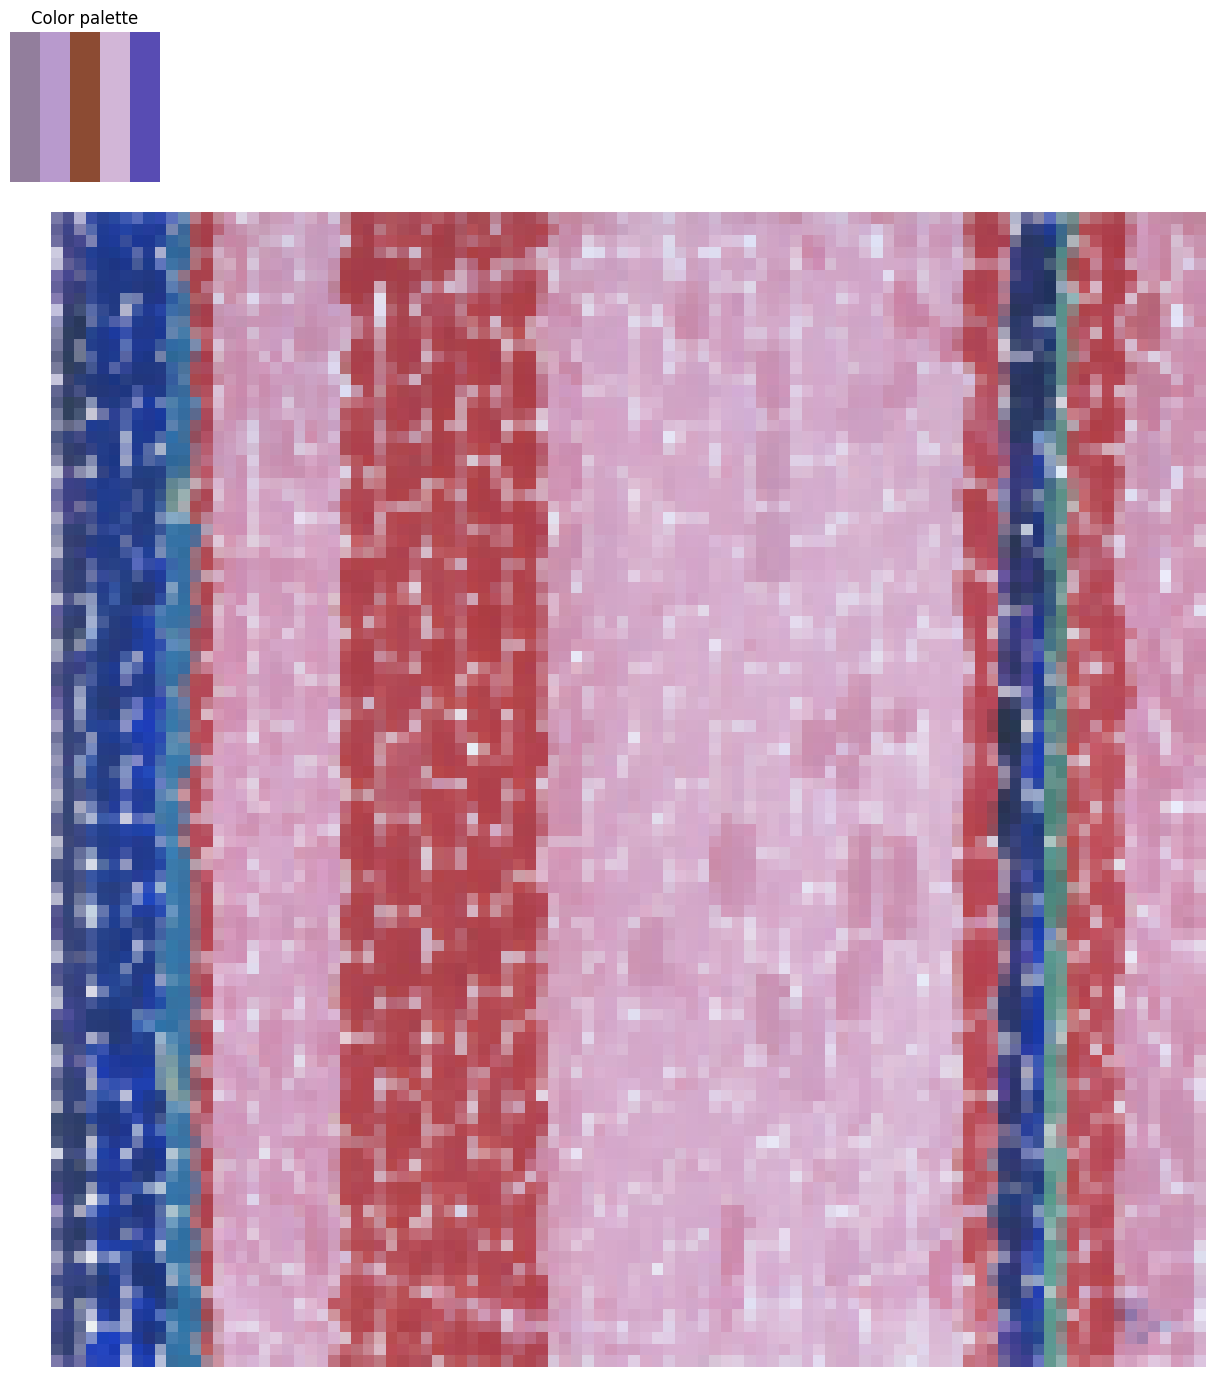

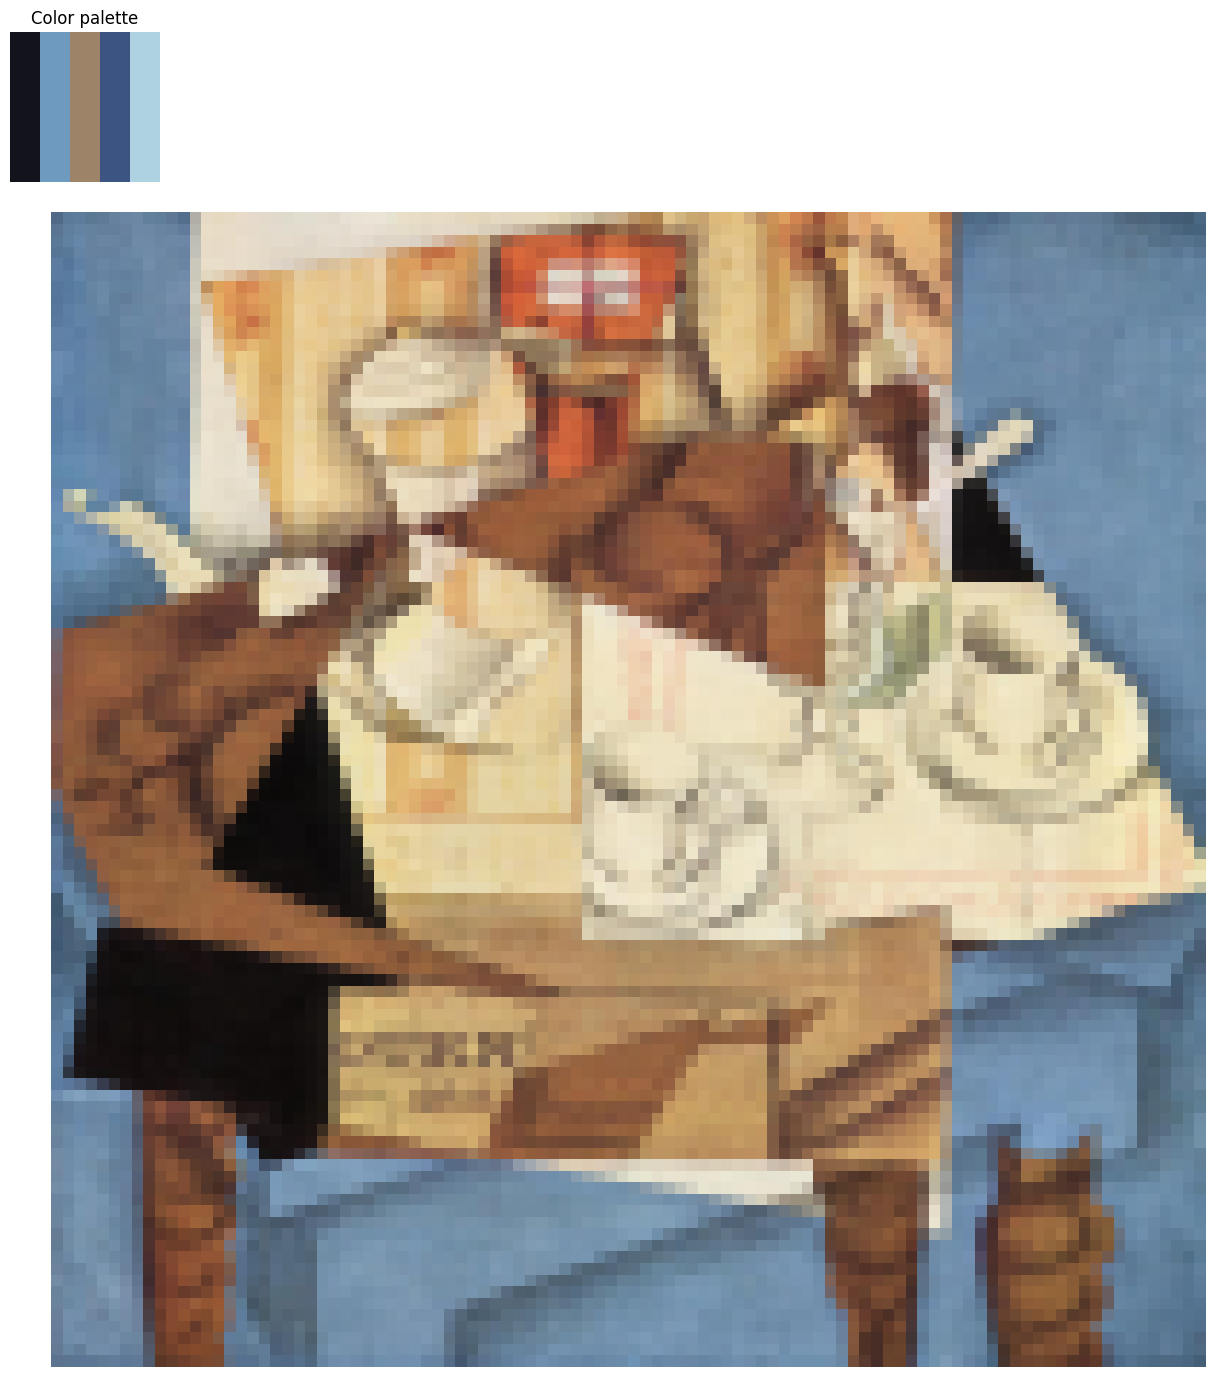

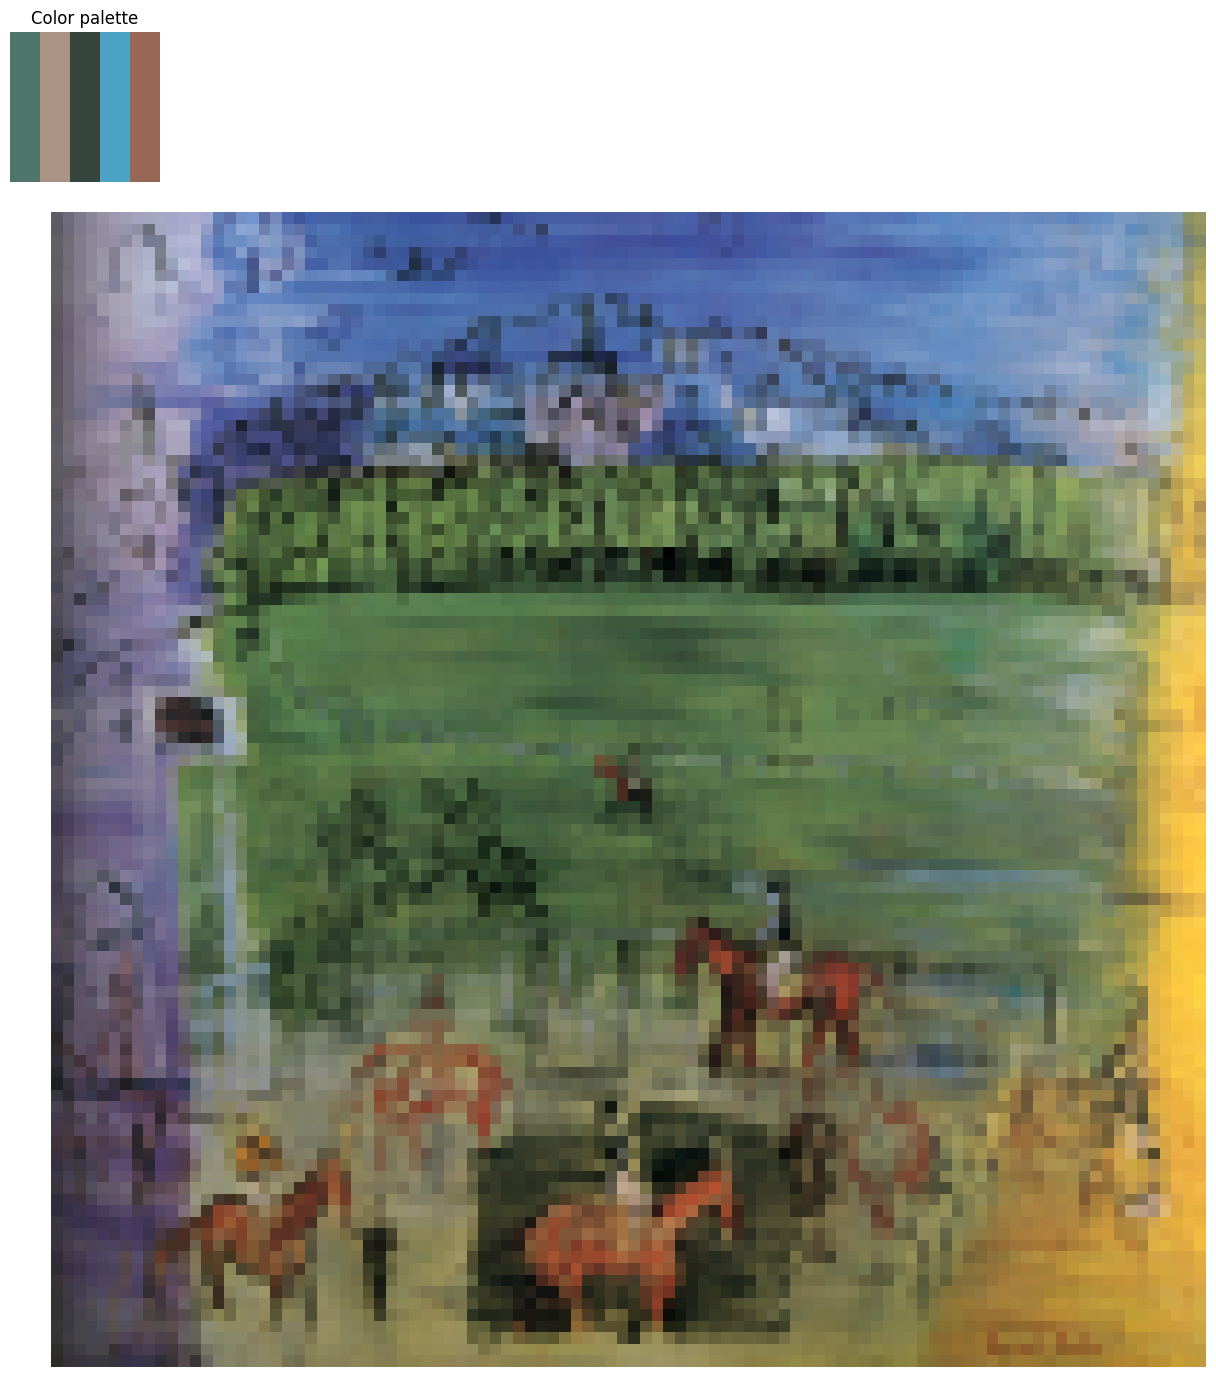

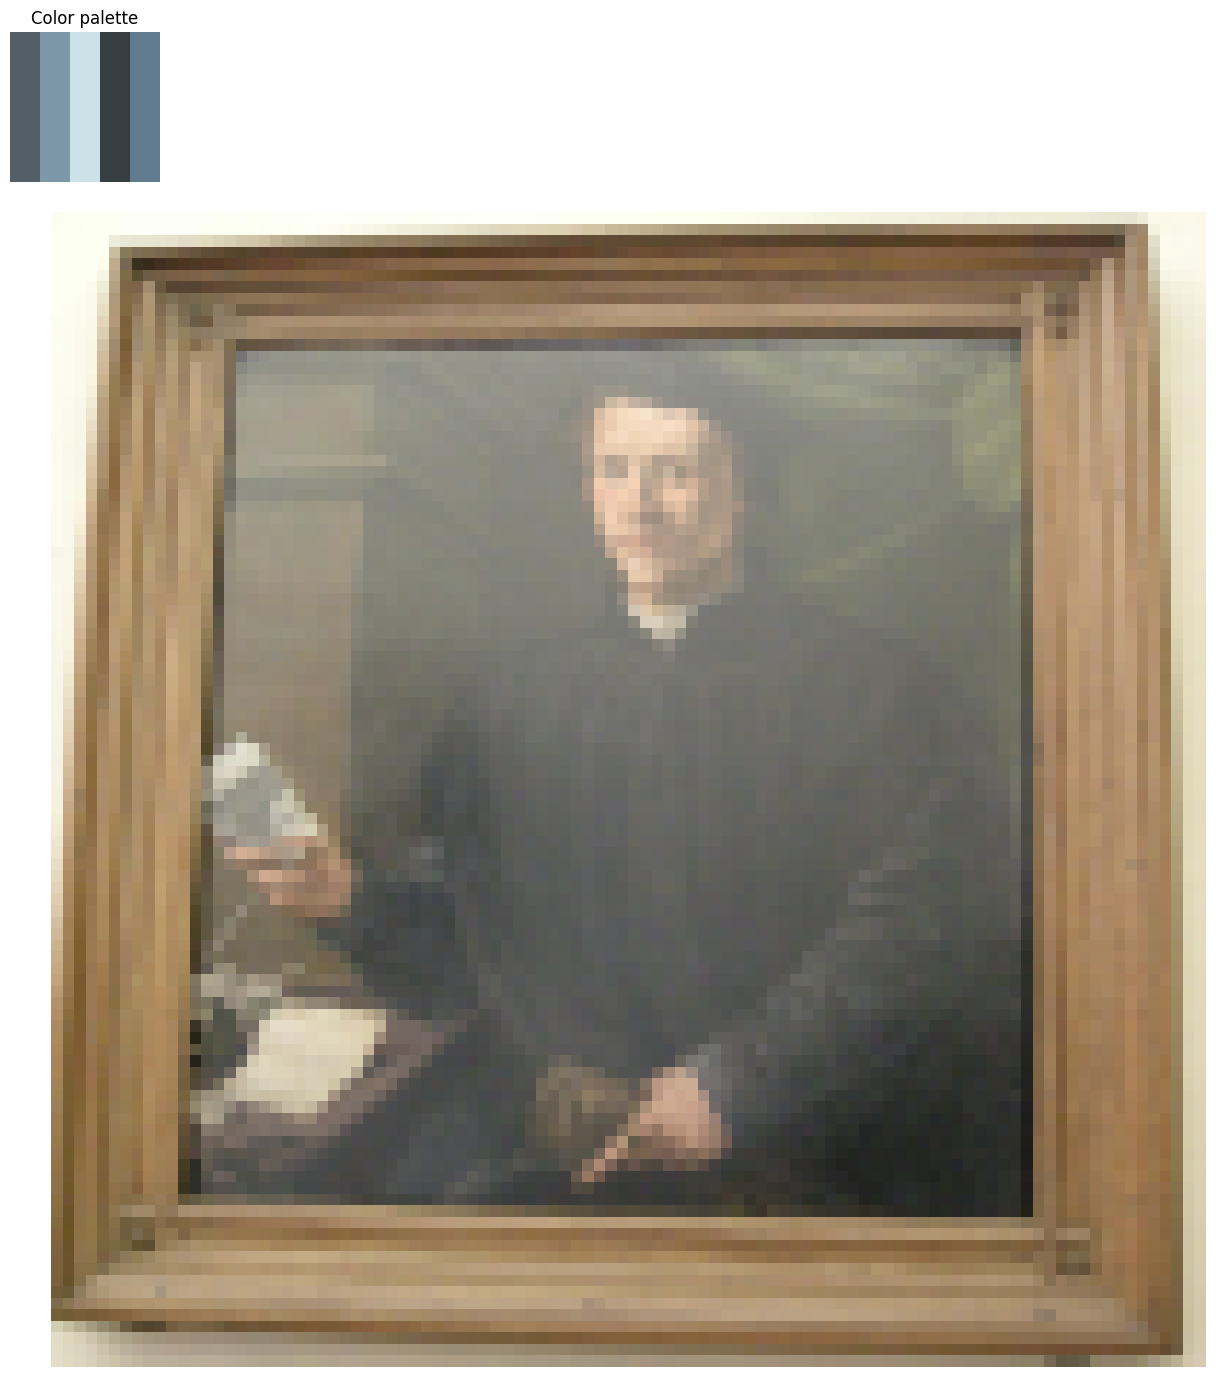

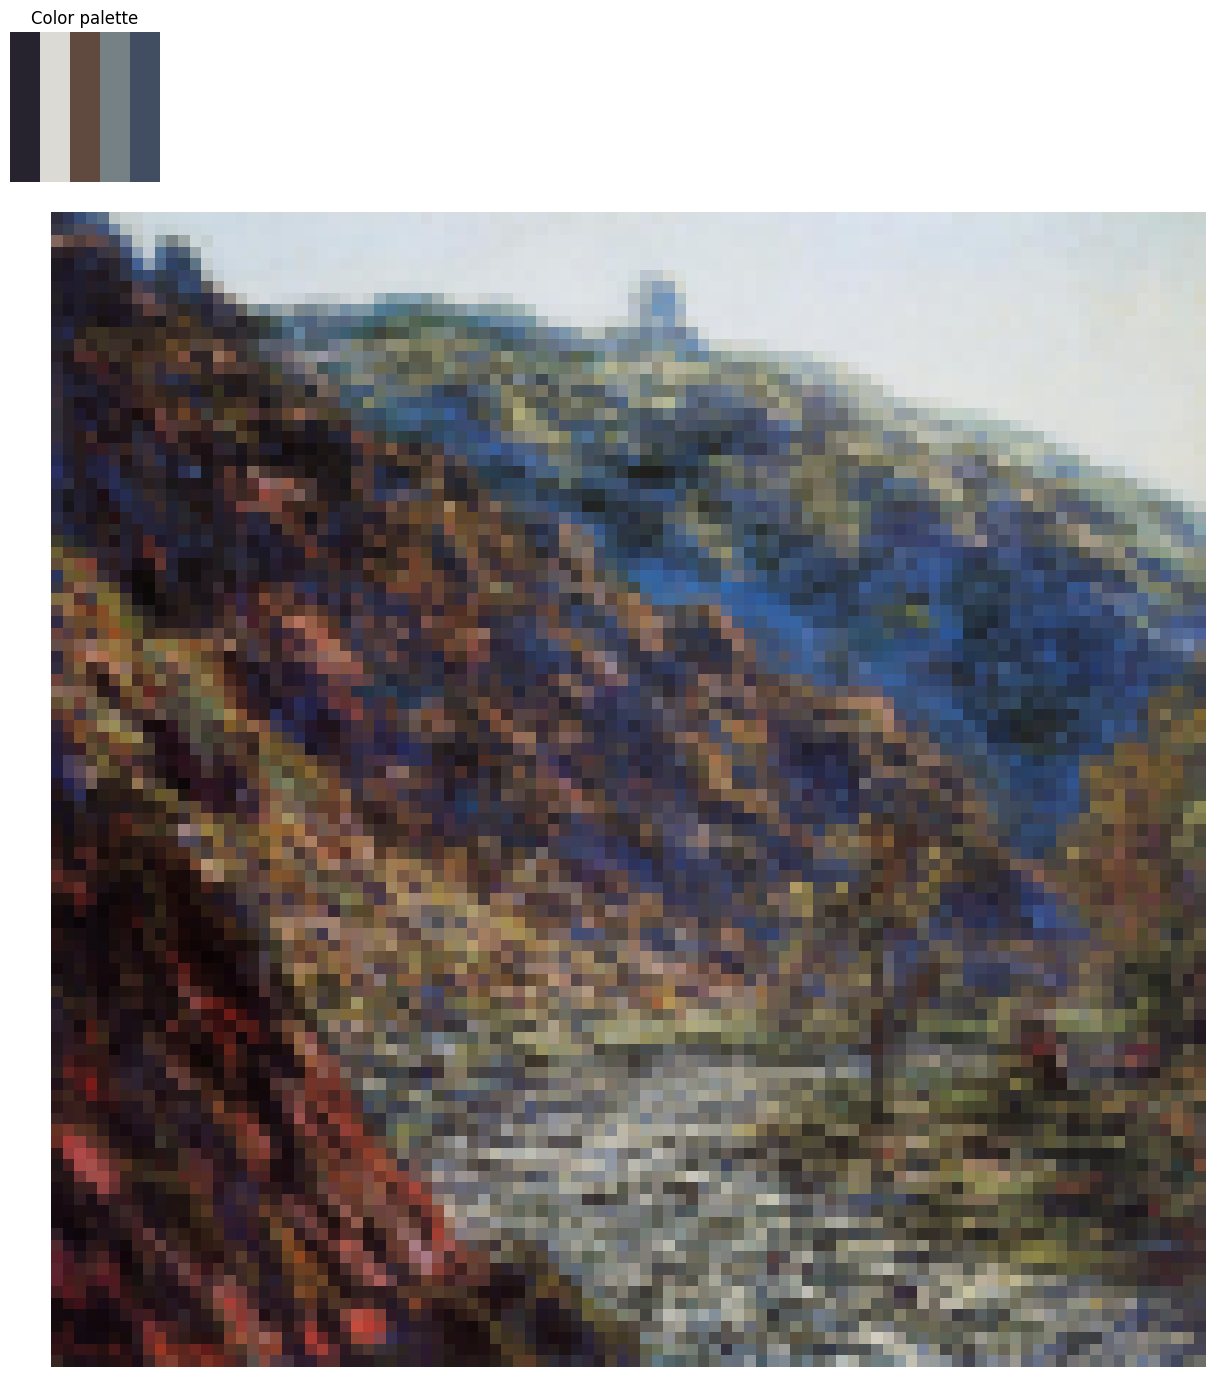

In [67]:
for i in range(5):
    model = PaletteGen(KMeans, n_clusters=5, n_init="auto")
    model.fit()
    model.plot_clusters()

Ademas, las clases estan diseñadas para permitir pasar como parametro el tamaño de la muestra de las imagenes, permitiendo entrenar el modelo con una coleccion de imagenes mayor a uno. Esto permite generar una paleta de colores para una coleccion general de imagenes. Es evidente que el desempeño bajo este contexto no es ideal debido a las posibles diversidades encontradas en una muestra aleatoria de imagenes. Notamos como se pierde la representacion de algunos colores dentro de la paleta por como se distribuyen los colores en todas las pinturas.

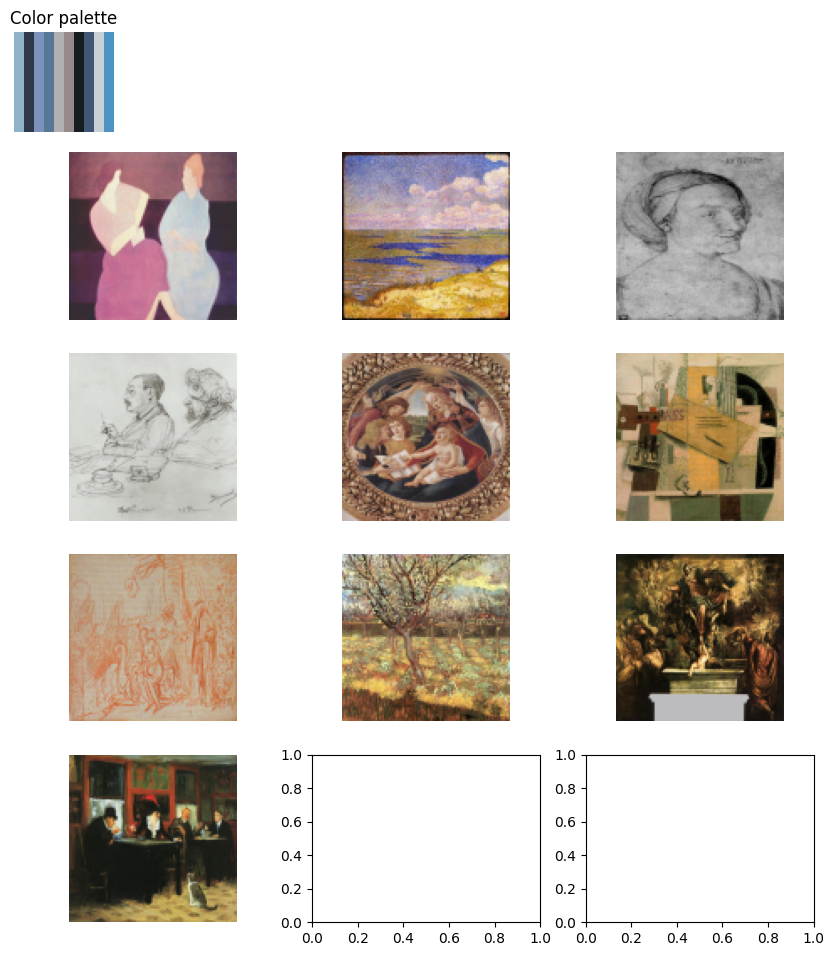

In [113]:
model2 = PaletteGen(KMeans, sample_ = 10, n_images=10, n_clusters=10, n_init="auto")
model2.fit()
model2.plot_clusters()

Gracias a como se definio el modelo, es posible generar paletar de colores de mayor tamaño, el siguiente es un ejemplo de una paleta con 8 colores distintos.

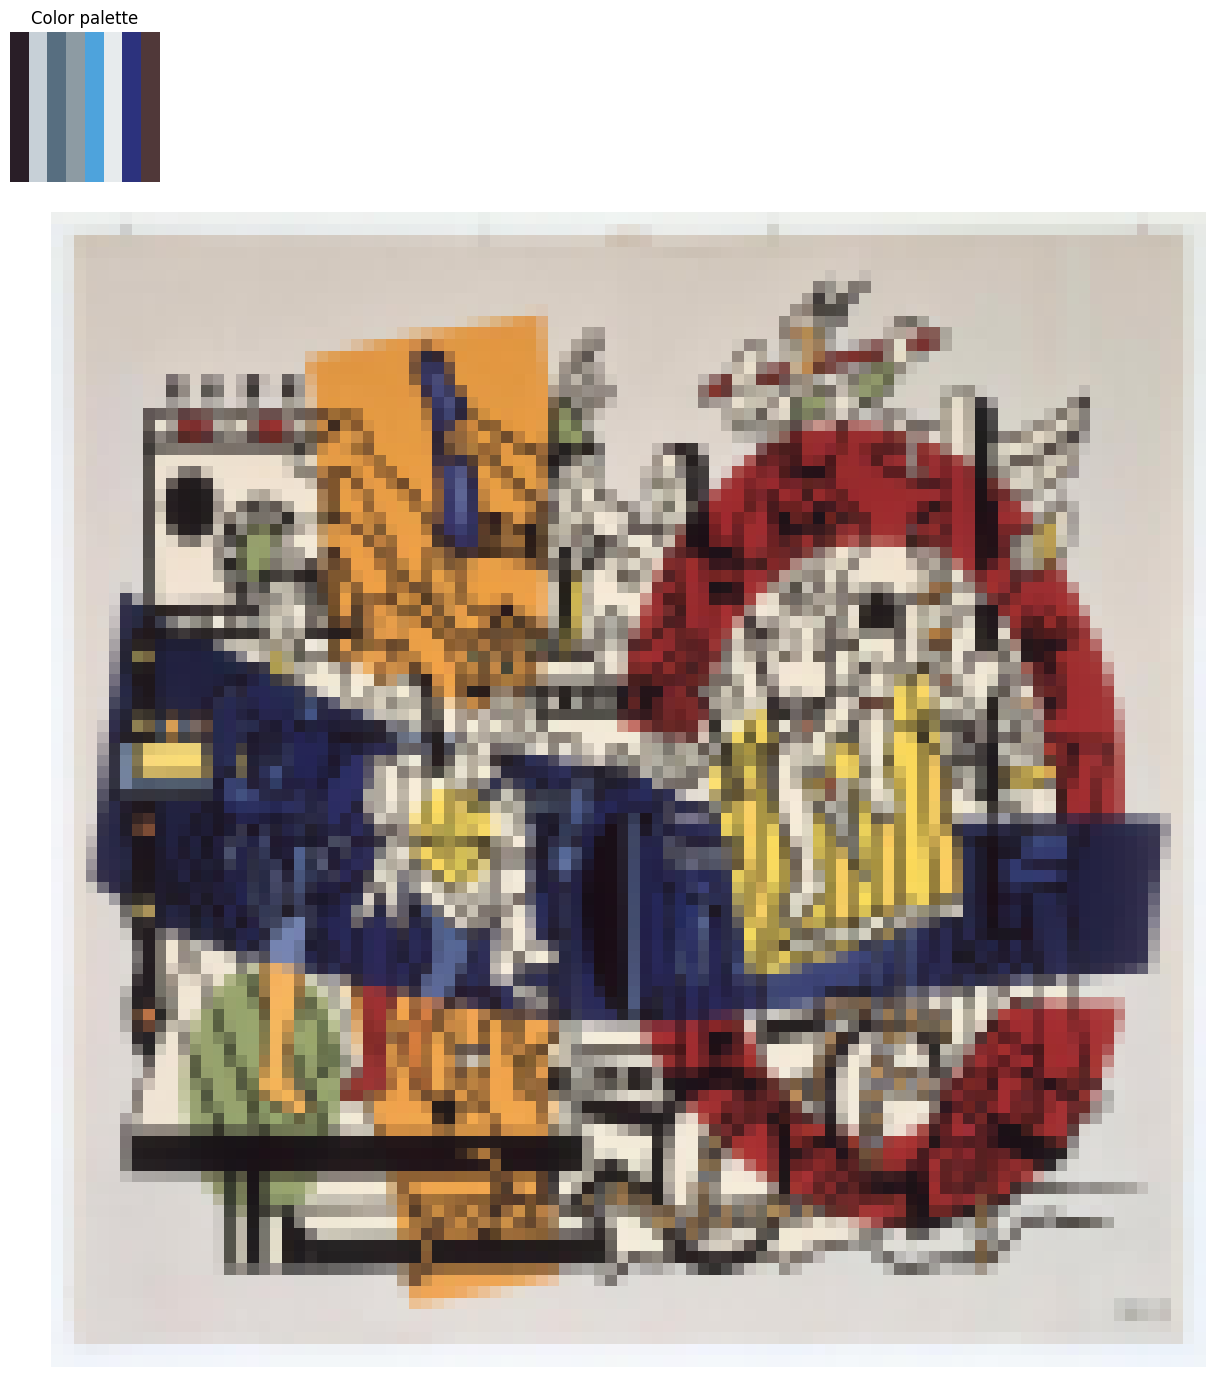

In [115]:
model3 = PaletteGen(KMeans, n_clusters=8, n_init="auto")
model3.fit()
model3.plot_clusters()

## Reduccion de la dimensionalidad

Finalmente, con herramientas de reduccion de la dimensionalidad podemos observar la proyeccion de los datos sobre sus componentes principales. En este caso podemos proyectar sobre el espacio de dos componentes y observar como se distribuyen los datos sobre este. Las graficas generadas permiten observar los componentes principales y la distribucion de los datos distinguiendo los puntos con colores de acuerdo al grupo asignado por el modelo. En algunos ejemplos es evidente que resulta natural y adecuado la agrupacion generada por el modelo.

In [101]:
class ReducedDimPlot:
    """
    Reduccion de la dimensionalidad de las imagenes, proyecta sobre los componentes principales obtenidos
    con PCA y t-SNE.

    Parametros:
        palettegen (PaletteGen): Clase modelo generador de paleta de colores.
    """
    def __init__(self, palettegen:PaletteGen, components):
        self.clusterer = palettegen
        self.pca = PCA(n_components=components)
        self.tsne = TSNE(n_components=components)
        self.pca_features = self.pca.fit_transform(self.clusterer.features)
        self.tsne_features = self.tsne.fit_transform(self.clusterer.features)

    def plot_biplot(self):
        """
        Visualiza el biplot de los componentes principales.
        """
        components_ = self.pca.components_
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        for i in range(self.pca.components_.shape[1]):
            ax.arrow(0, 0, components_[0, i], components_[1, i], head_width=0.05, head_length=0.1, fc='r', ec='r')
            ax.text(components_[0, i], components_[1, i], self.clusterer.features.columns[i])
        ax.set_xlabel('First principal component')
        ax.set_ylabel('Second principal component')
        plt.show()

    def plot_pca(self):
        """
        Visualiza la proyeccion de los datos sobre los componentes principales.
        """
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.scatter(self.pca_features[:, 0], self.pca_features[:, 1], c=self.clusterer.pipeline.named_steps['clusterer'].labels_)
        ax.set_xlabel('Primer componente')
        ax.set_ylabel('Segundo componente')
        ax.set_title('PCA')
        plt.show()


    def plot_tsne(self):
        """
        Visualiza la proyeccion de los datos sobre los componentes t-SNE.
        """
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.scatter(self.tsne_features[:, 0], self.tsne_features[:, 1], c=self.clusterer.pipeline.named_steps['clusterer'].labels_)
        ax.set_xlabel('Primer componente')
        ax.set_ylabel('Segundo componente')
        ax.set_title('t-SNE')
        plt.show()


In [102]:
class Visualizer:
    """
    Automatiza el proceso de visualizacion de los resultados del modelo y su proyeccion sobre el plano.

    Parametros:
        n_images (int): Numero de imagenes a usar.
        components_ (int): Numero de componentes a usar.
    """
    def __init__(self, n_images, components_ = 2):
        self.sample = [PaletteGen(KMeans, n_clusters=5, n_init="auto") for i in range(n_images)]
        self.dimreducer = ReducedDimPlot
        self.components = components_

    def plot(self, n):
        """
        Visualiza los resultados del modelo y su proyeccion sobre el plano.
        """
        sample = self.sample[n]
        sample.fit()
        sample.plot_clusters()
        dimred = self.dimreducer(sample, self.components)
        dimred.plot_biplot()
        dimred.plot_pca()
        dimred.plot_tsne()


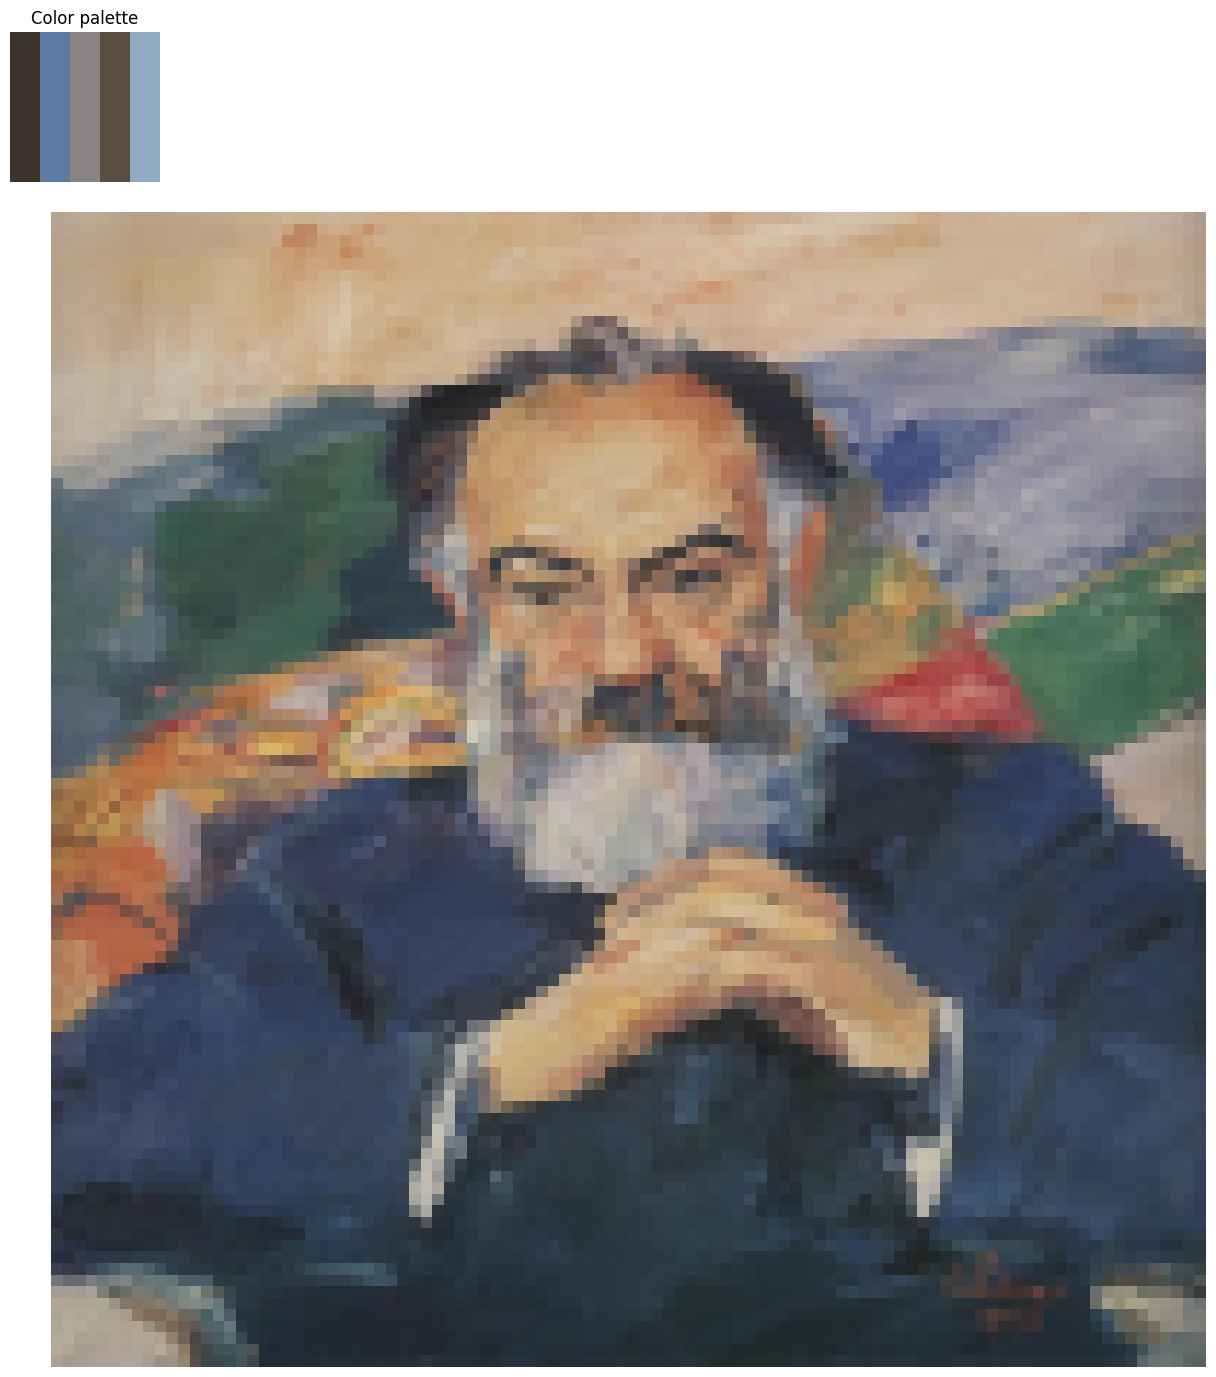

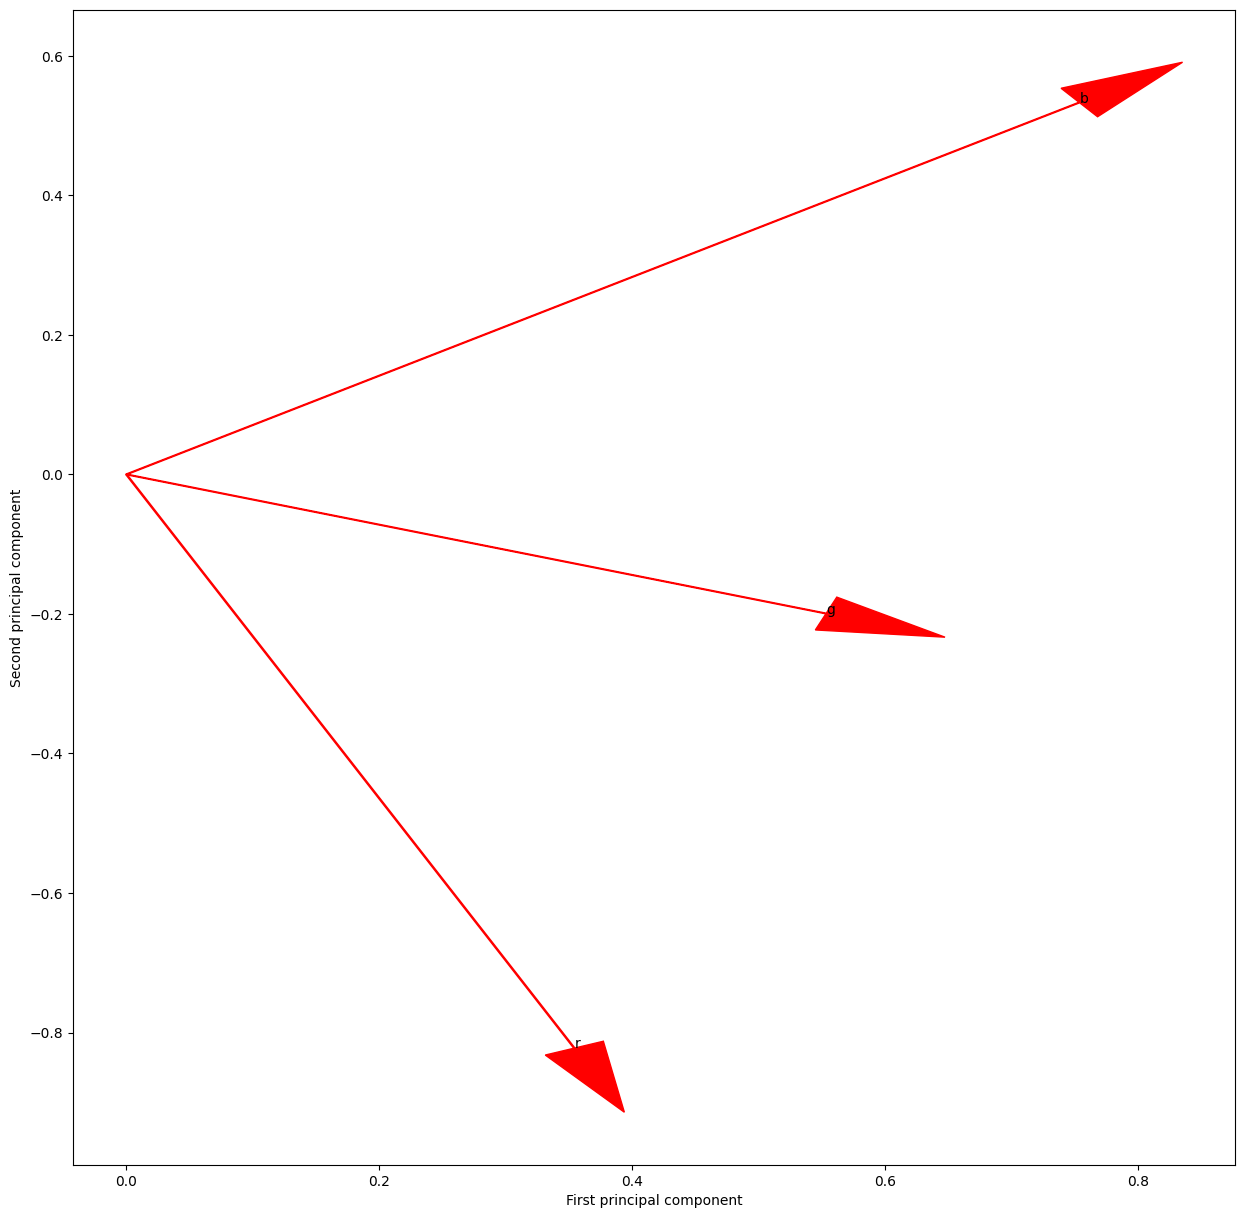

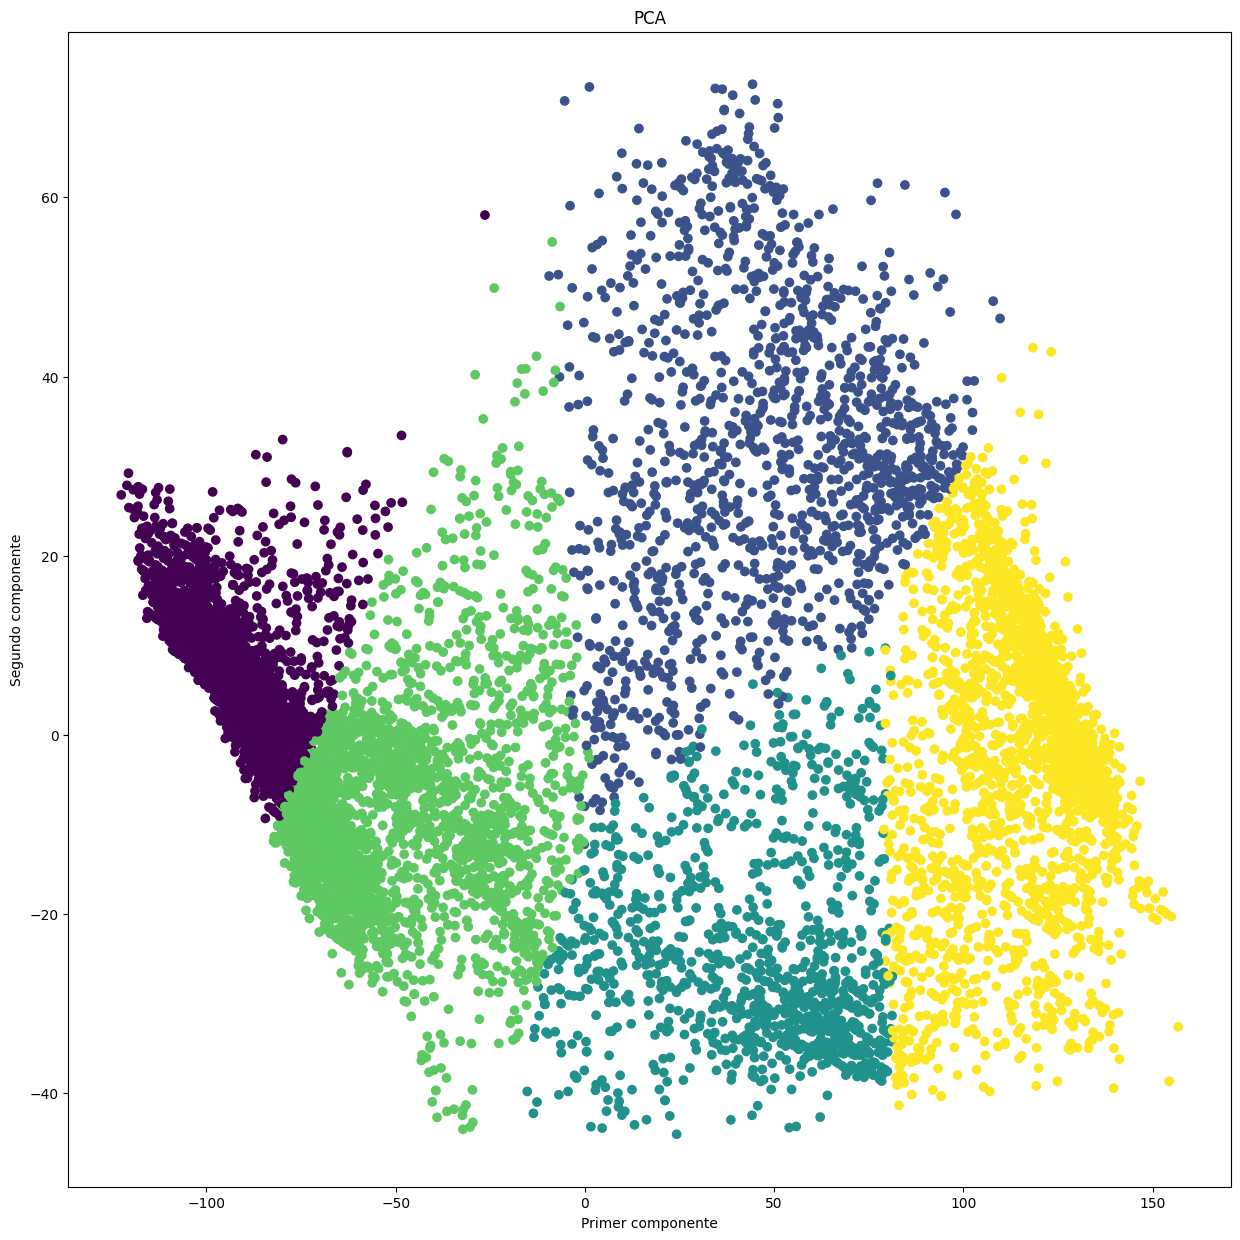

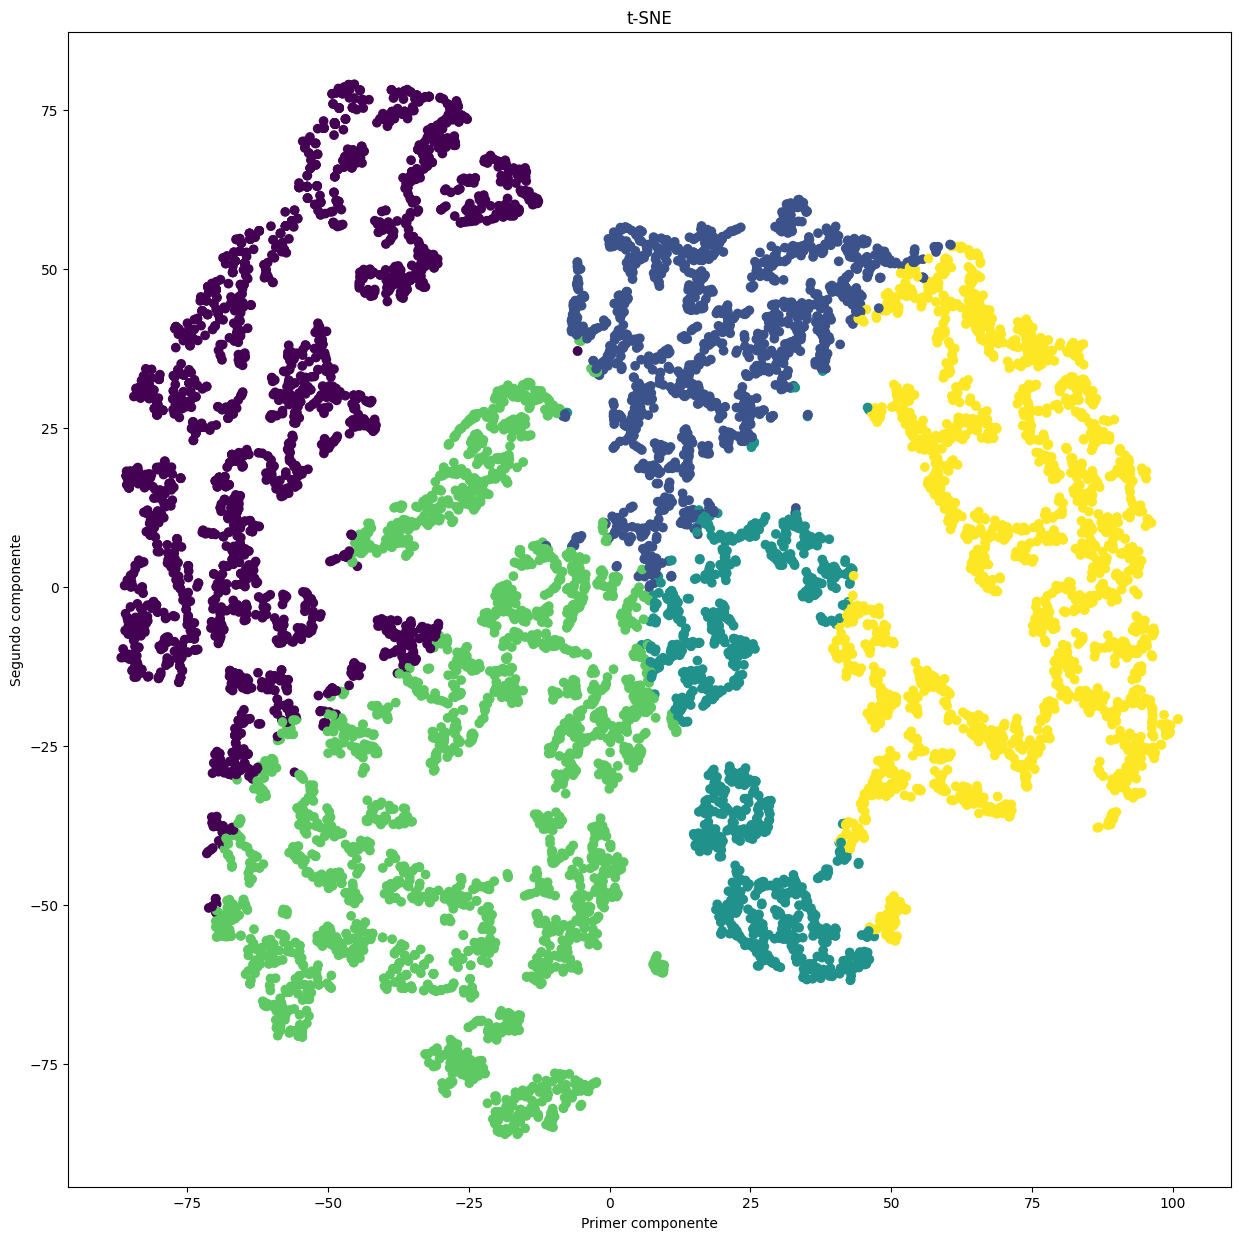

In [103]:
visual = Visualizer(5)
visual.plot(0)

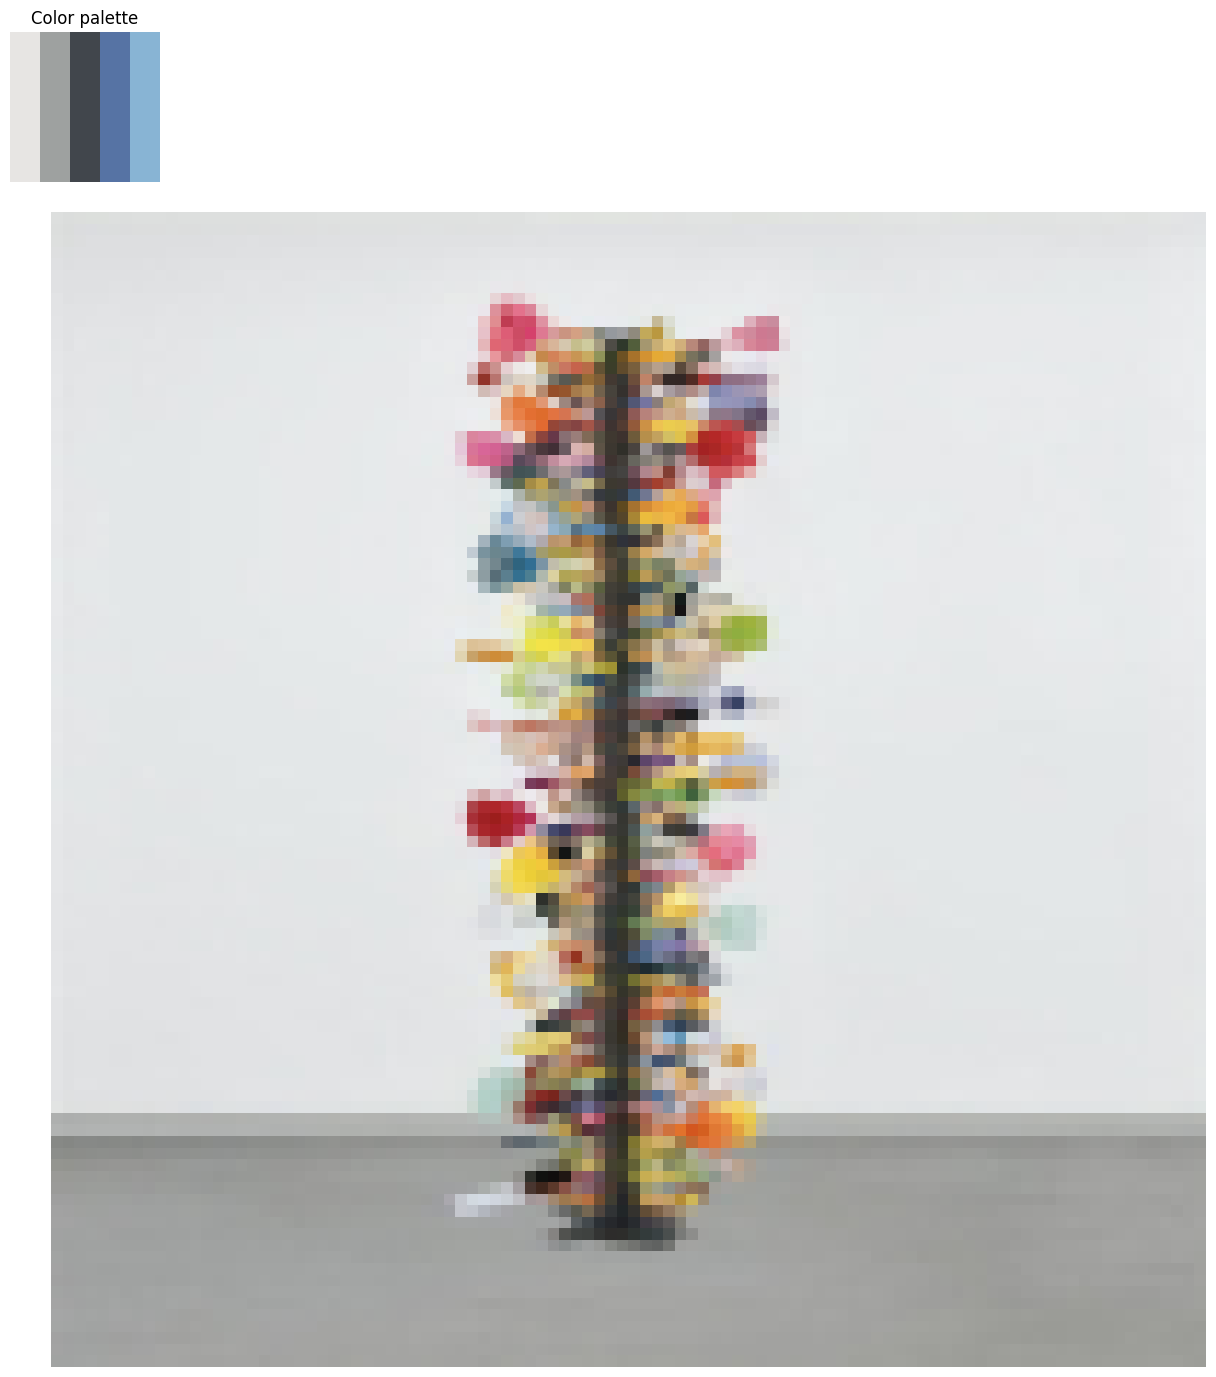

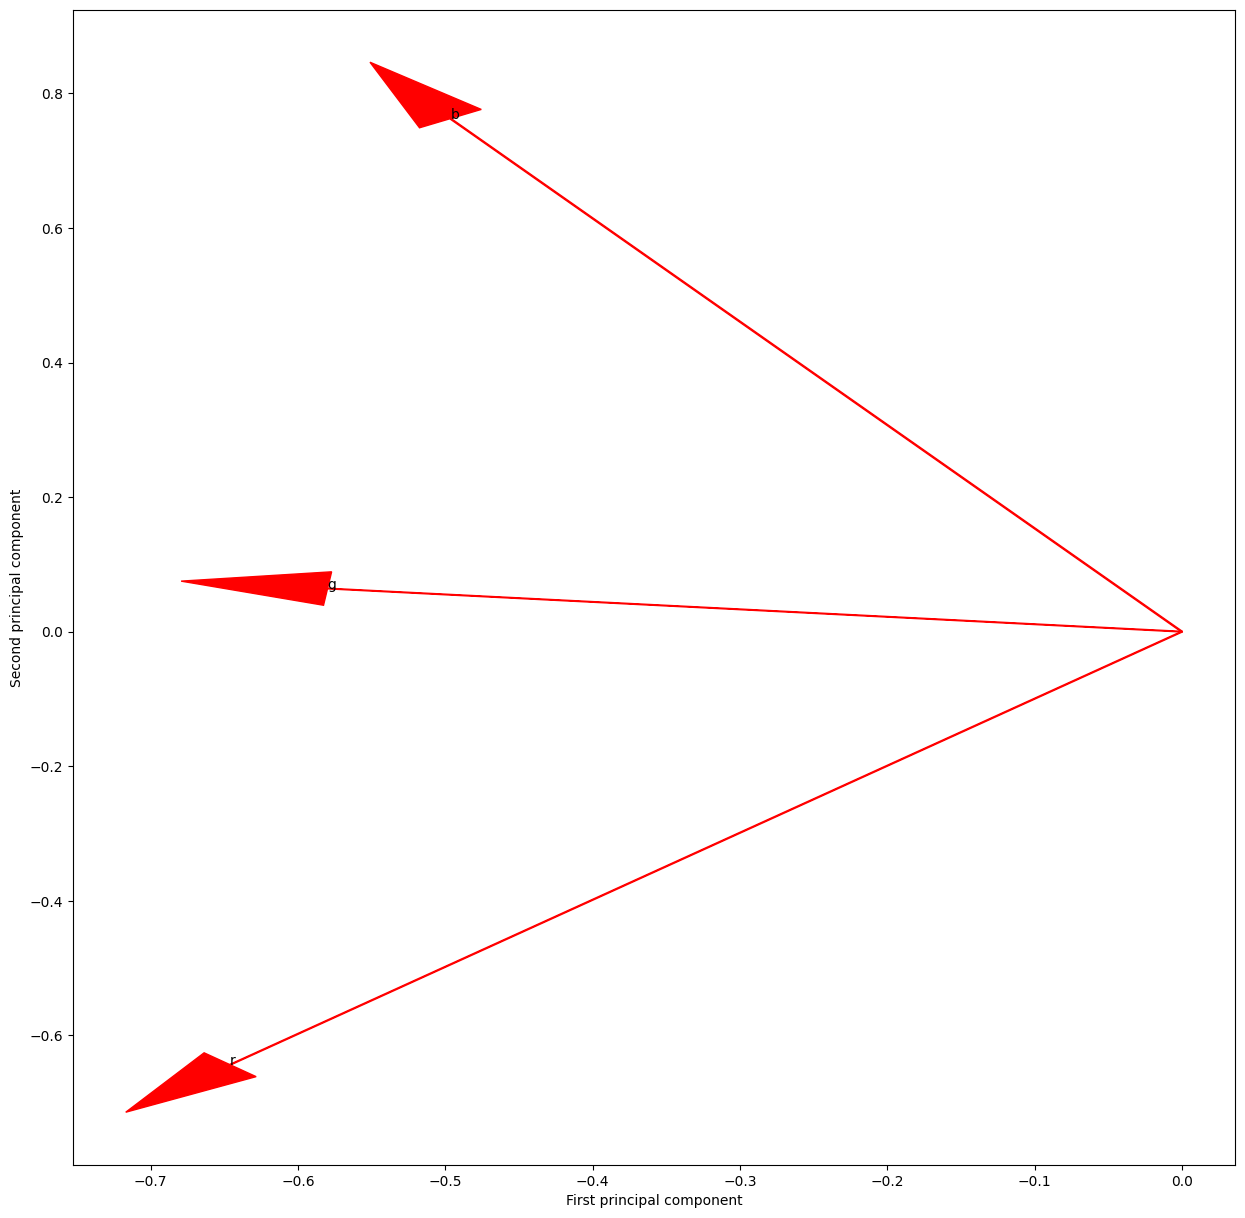

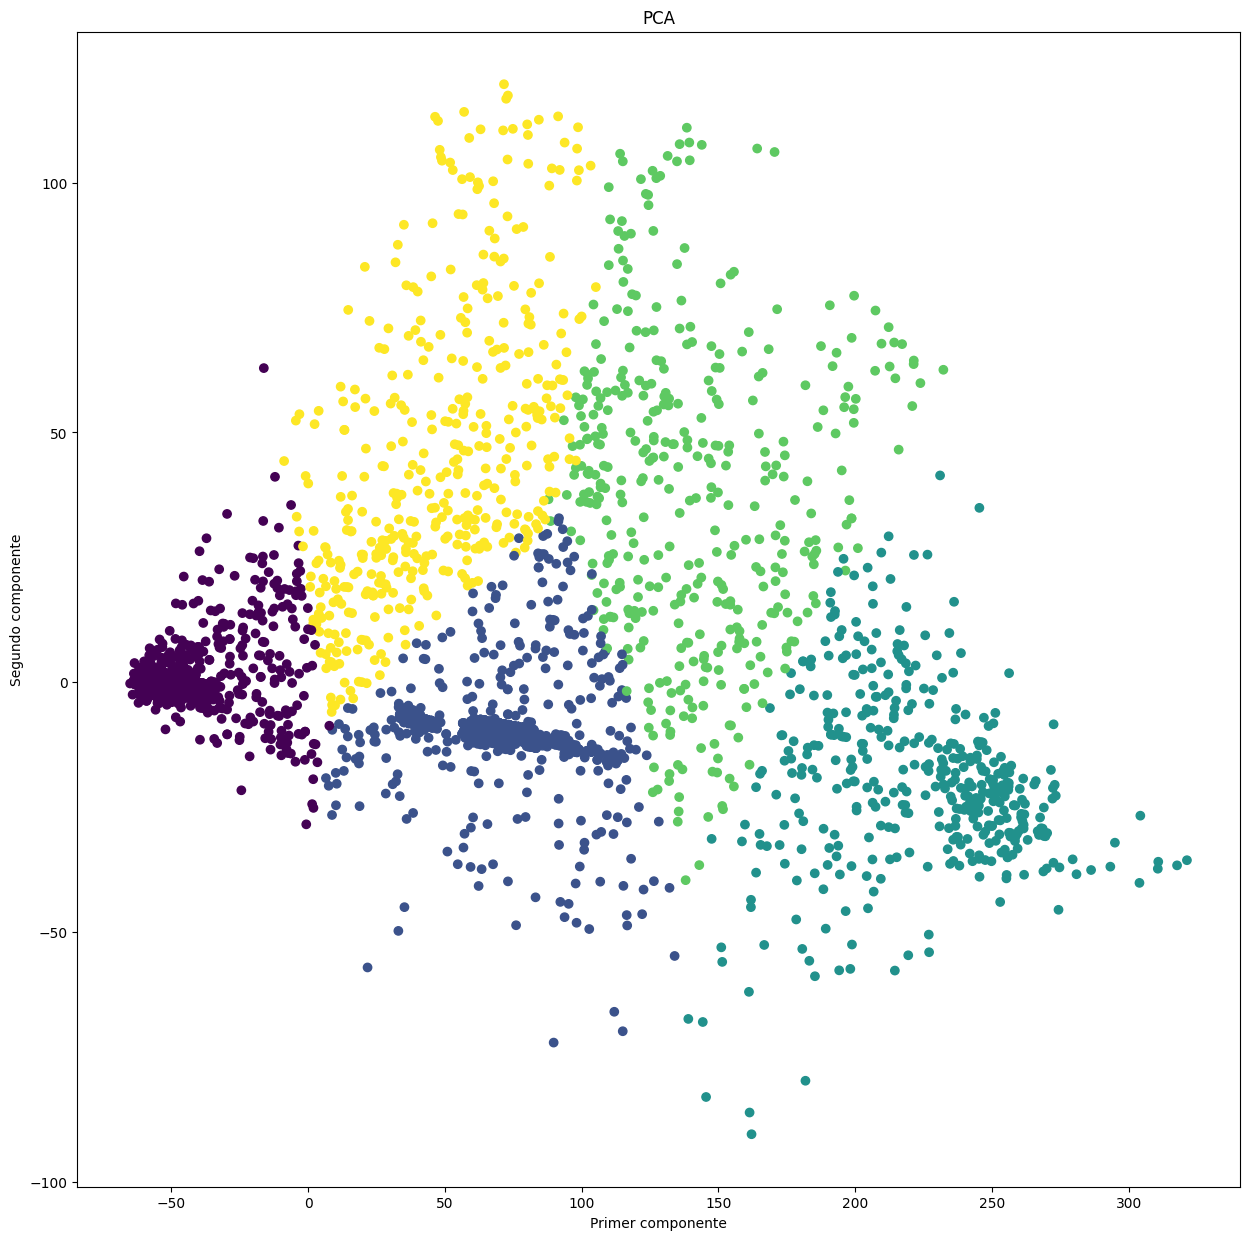

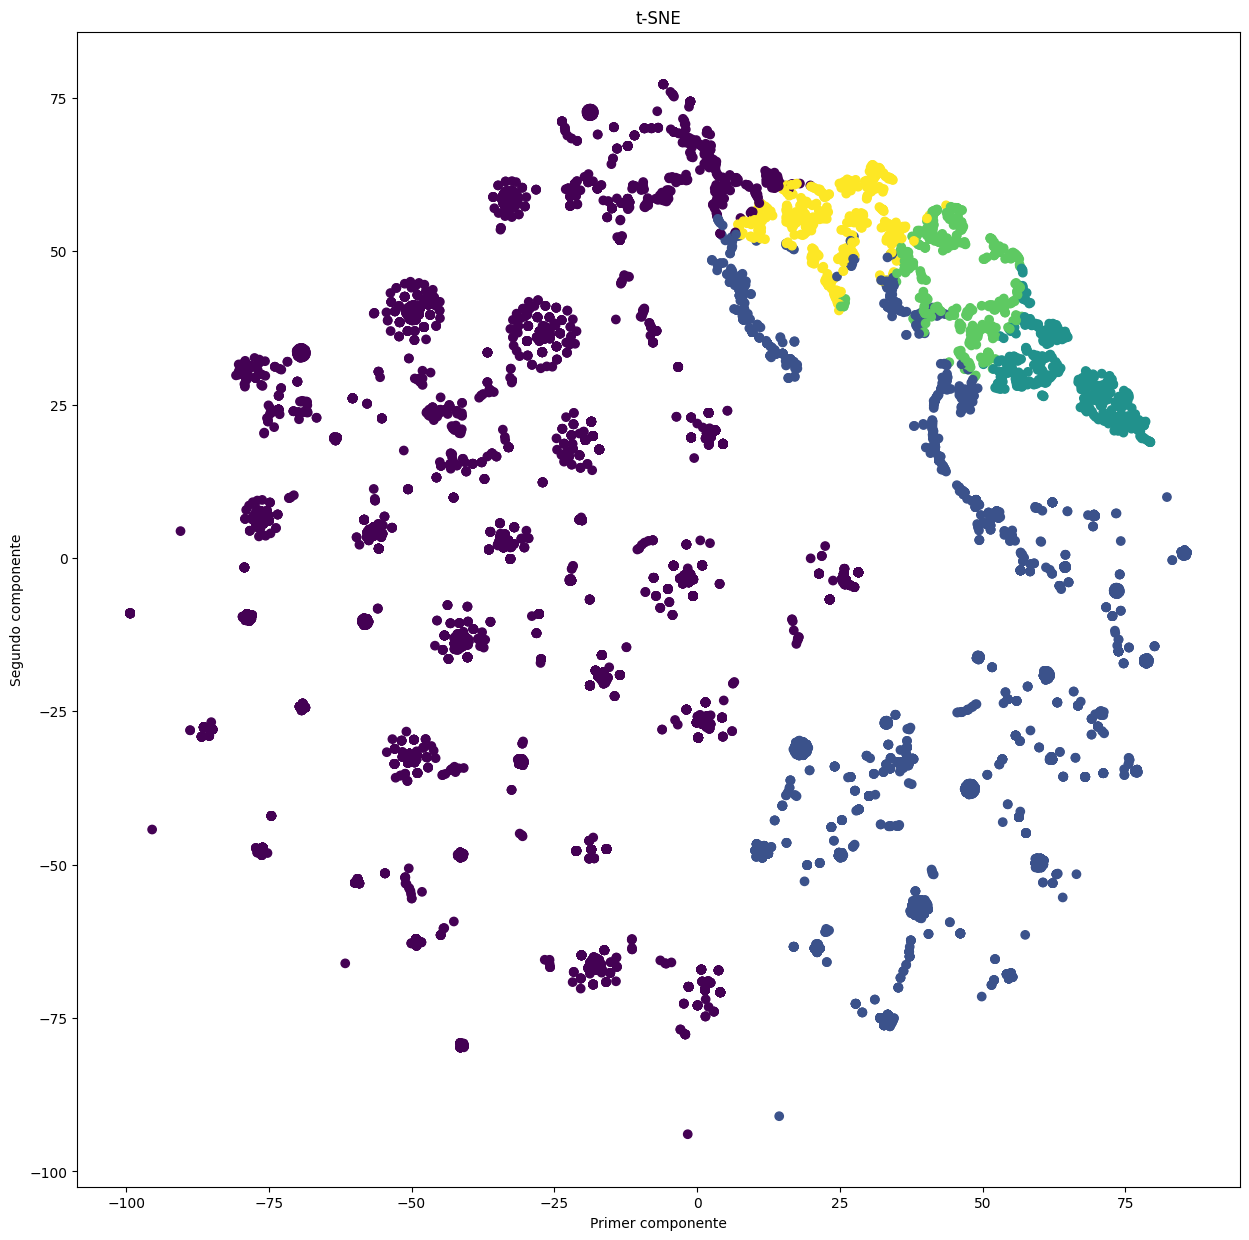

In [104]:
visual.plot(1)

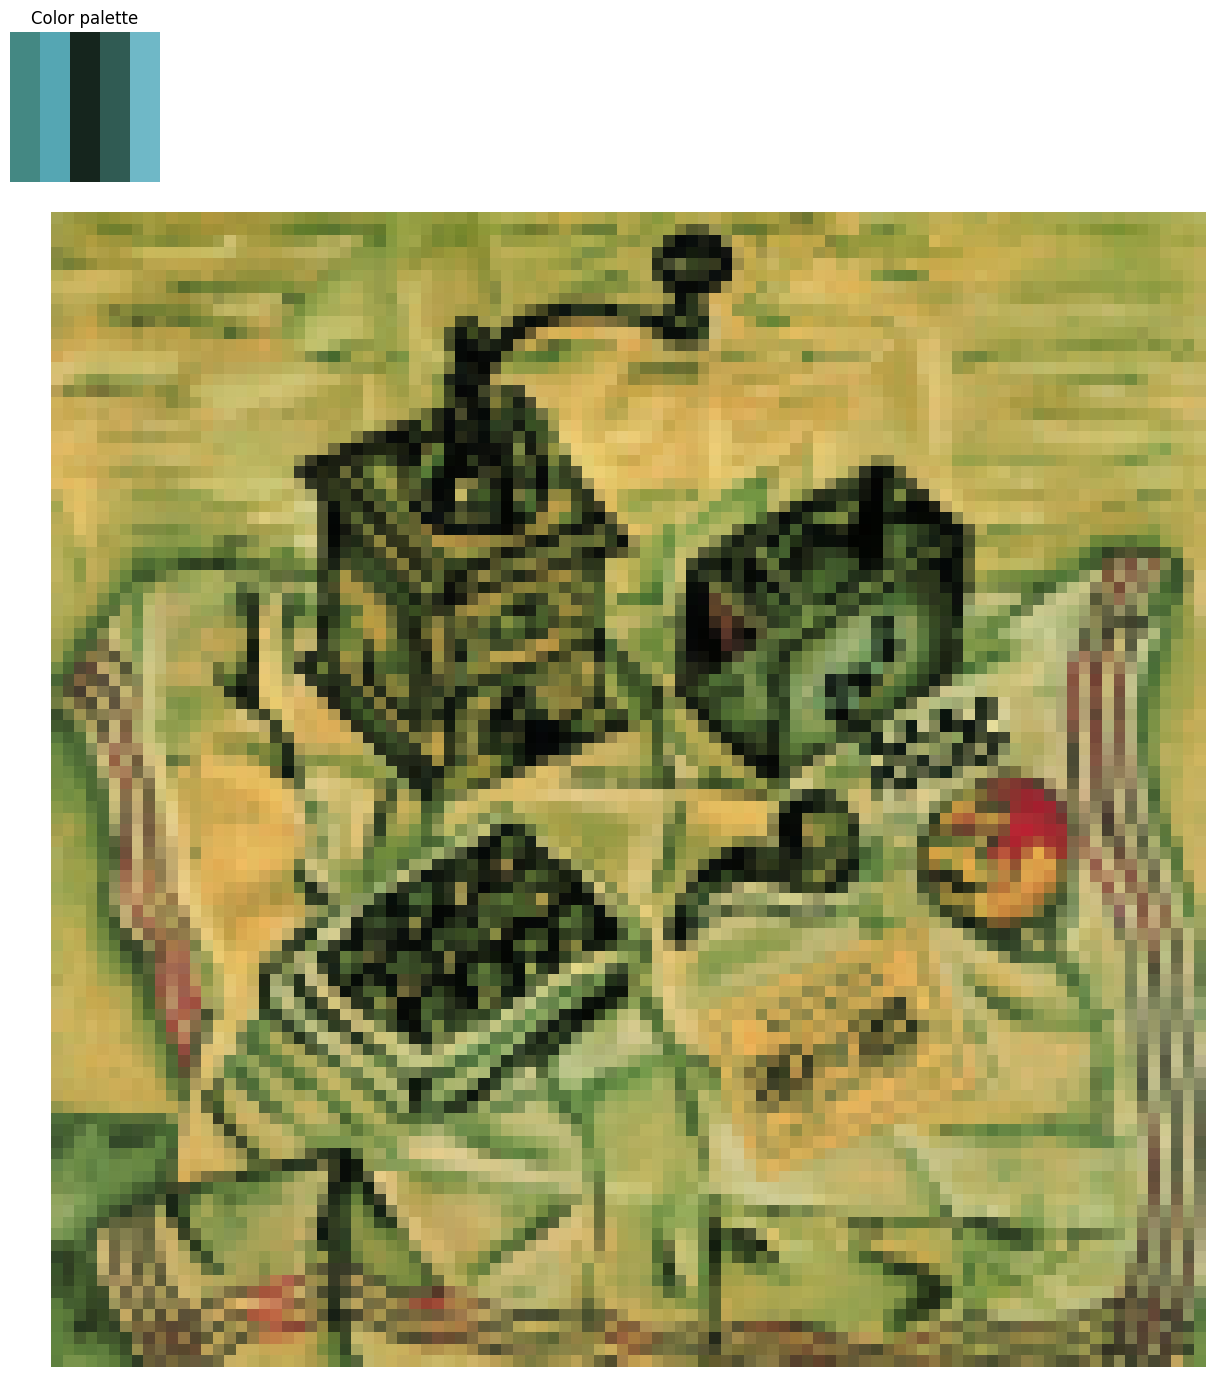

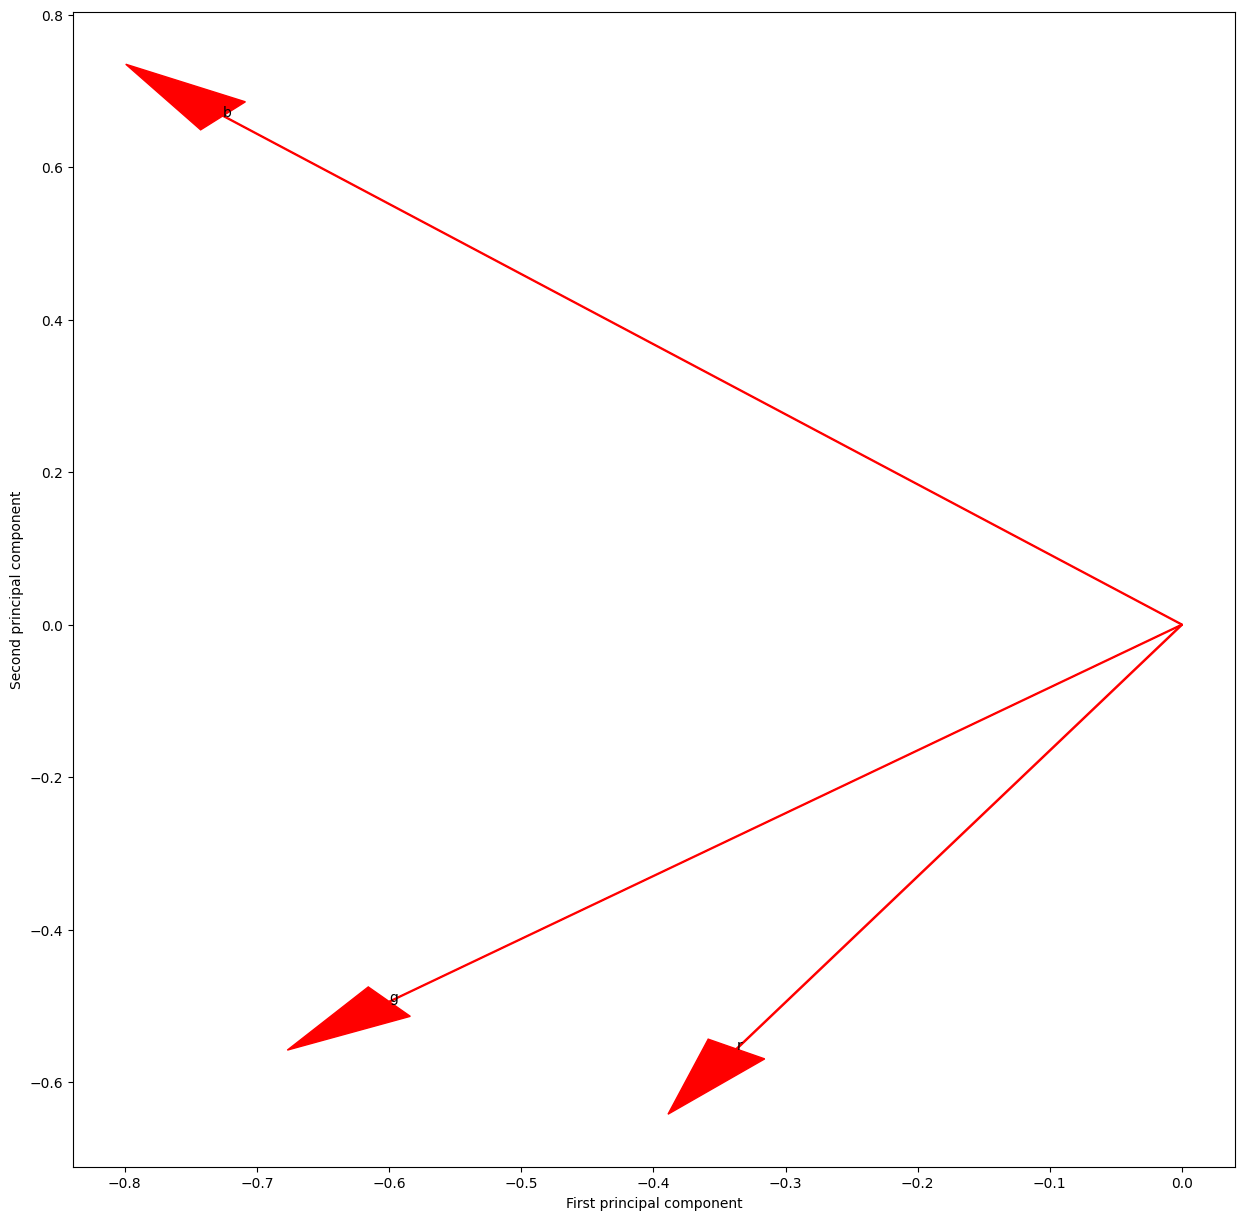

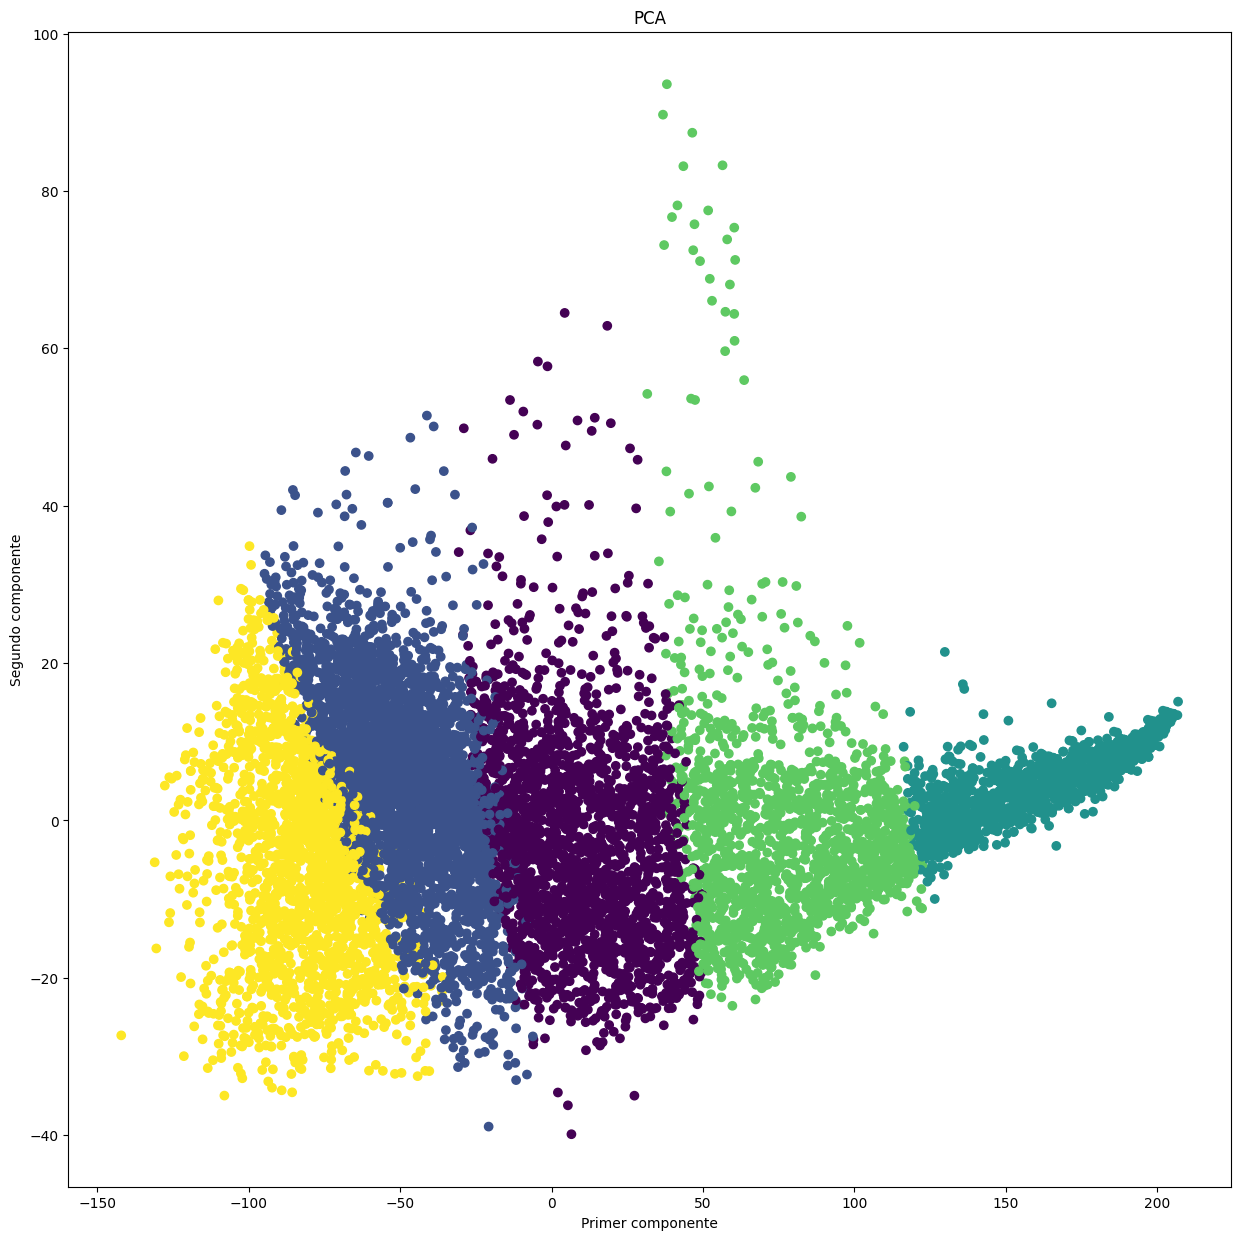

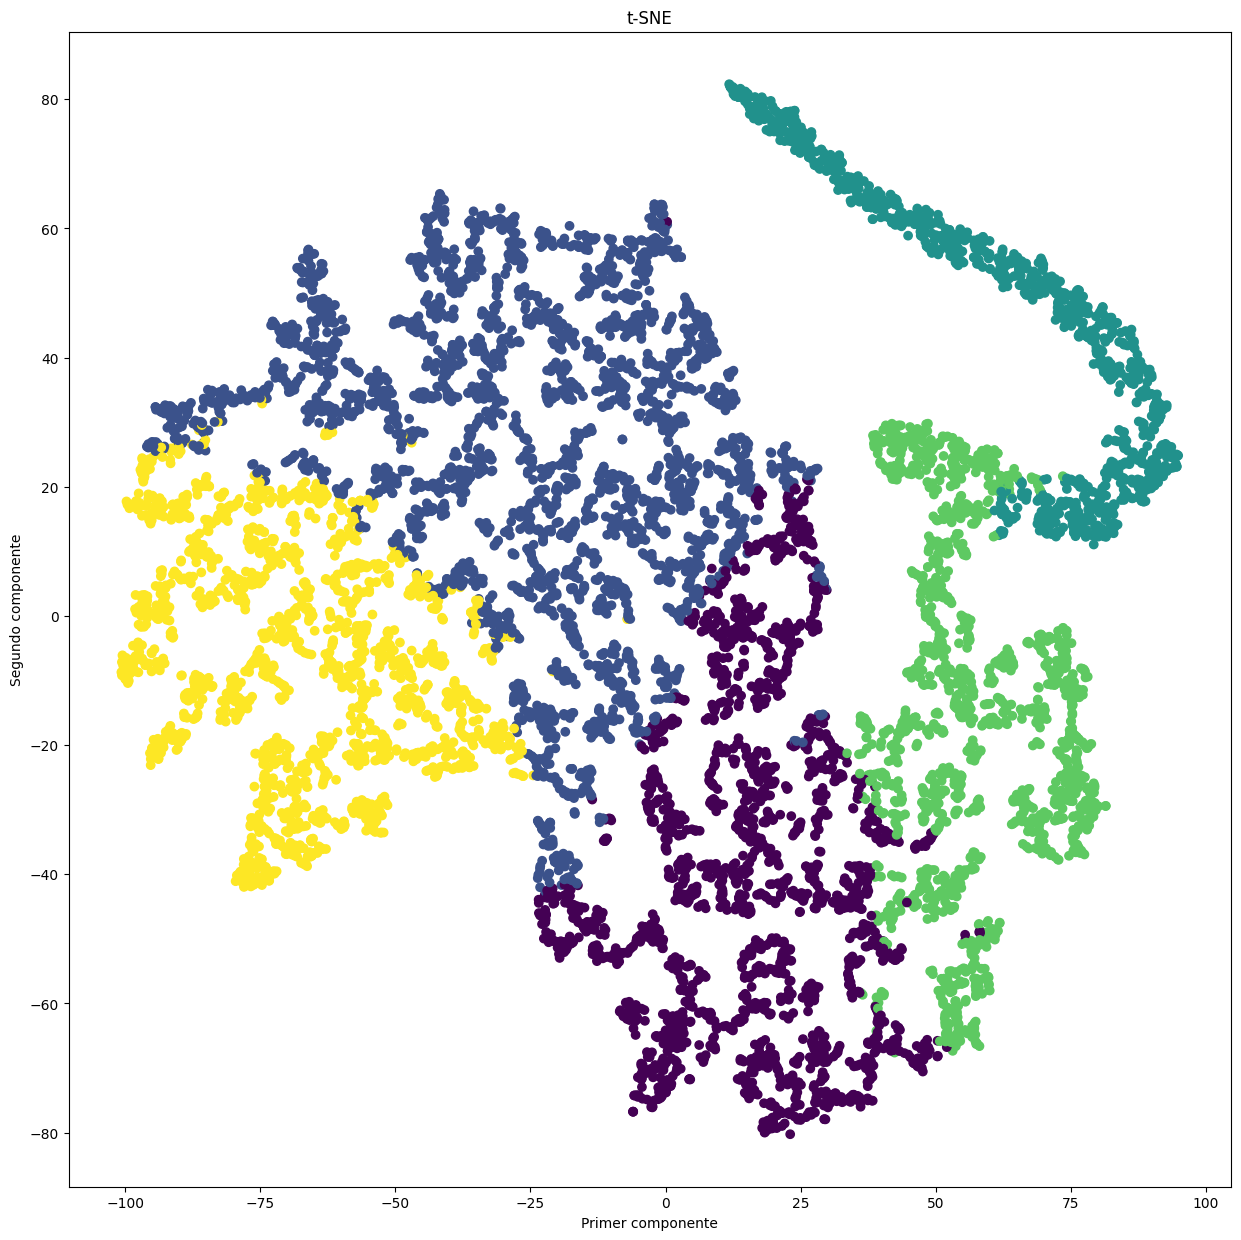

In [105]:
visual.plot(2)

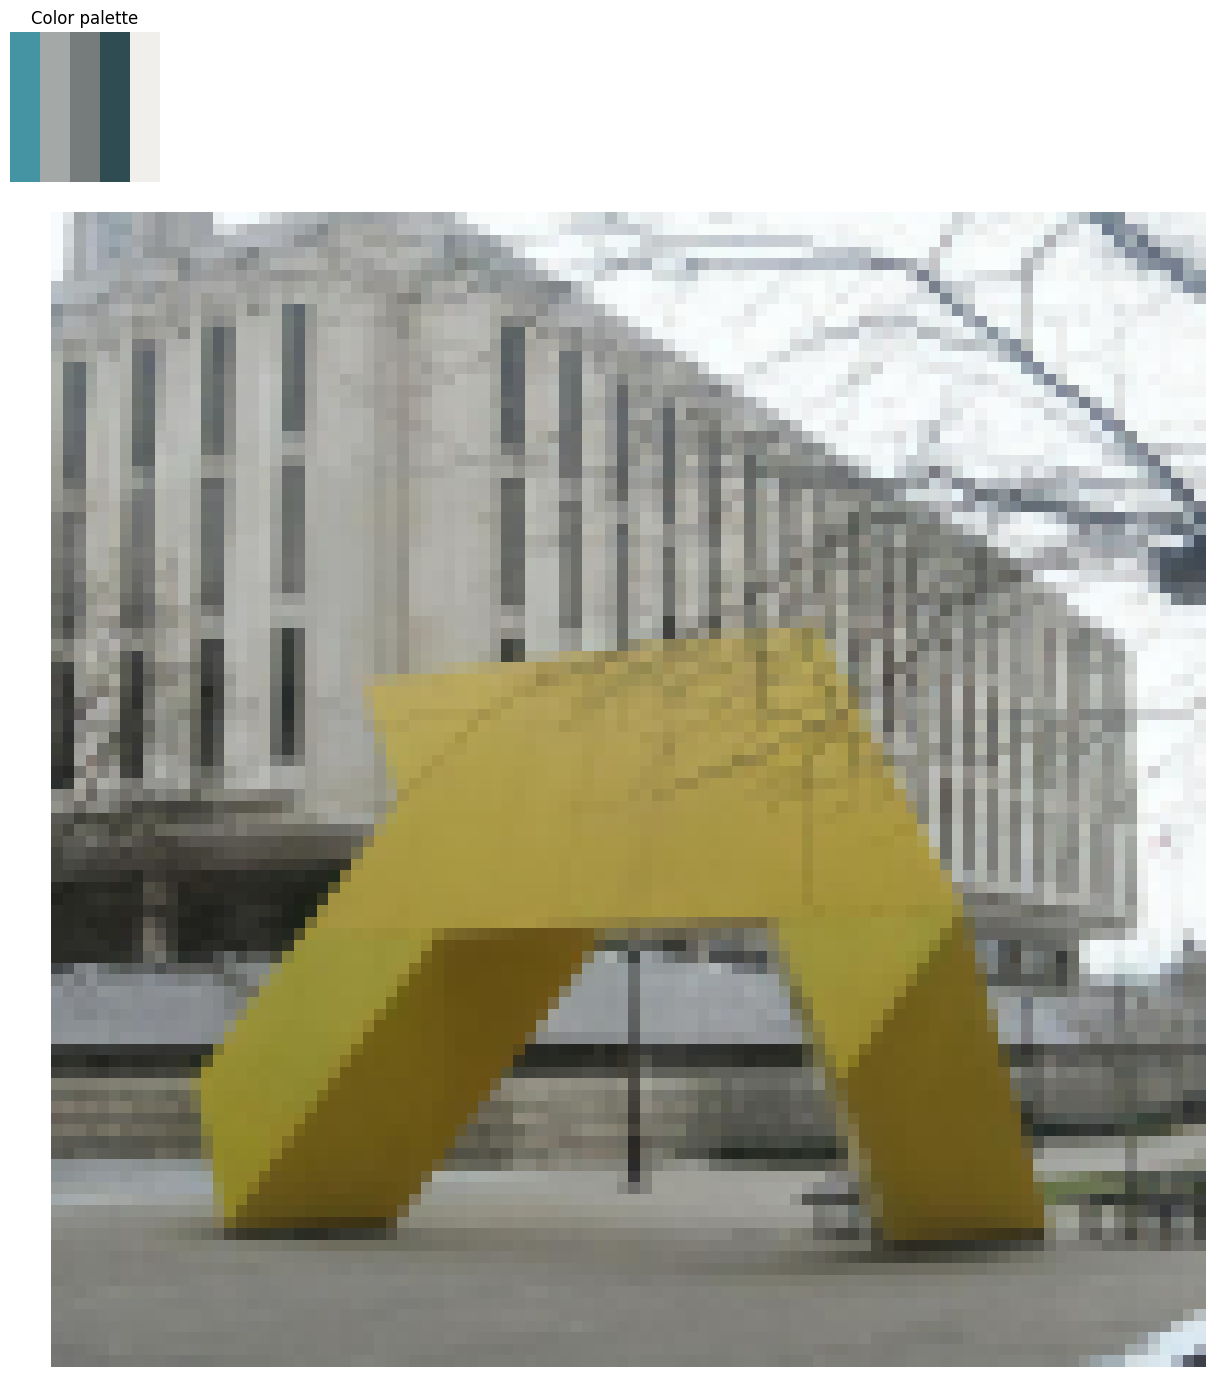

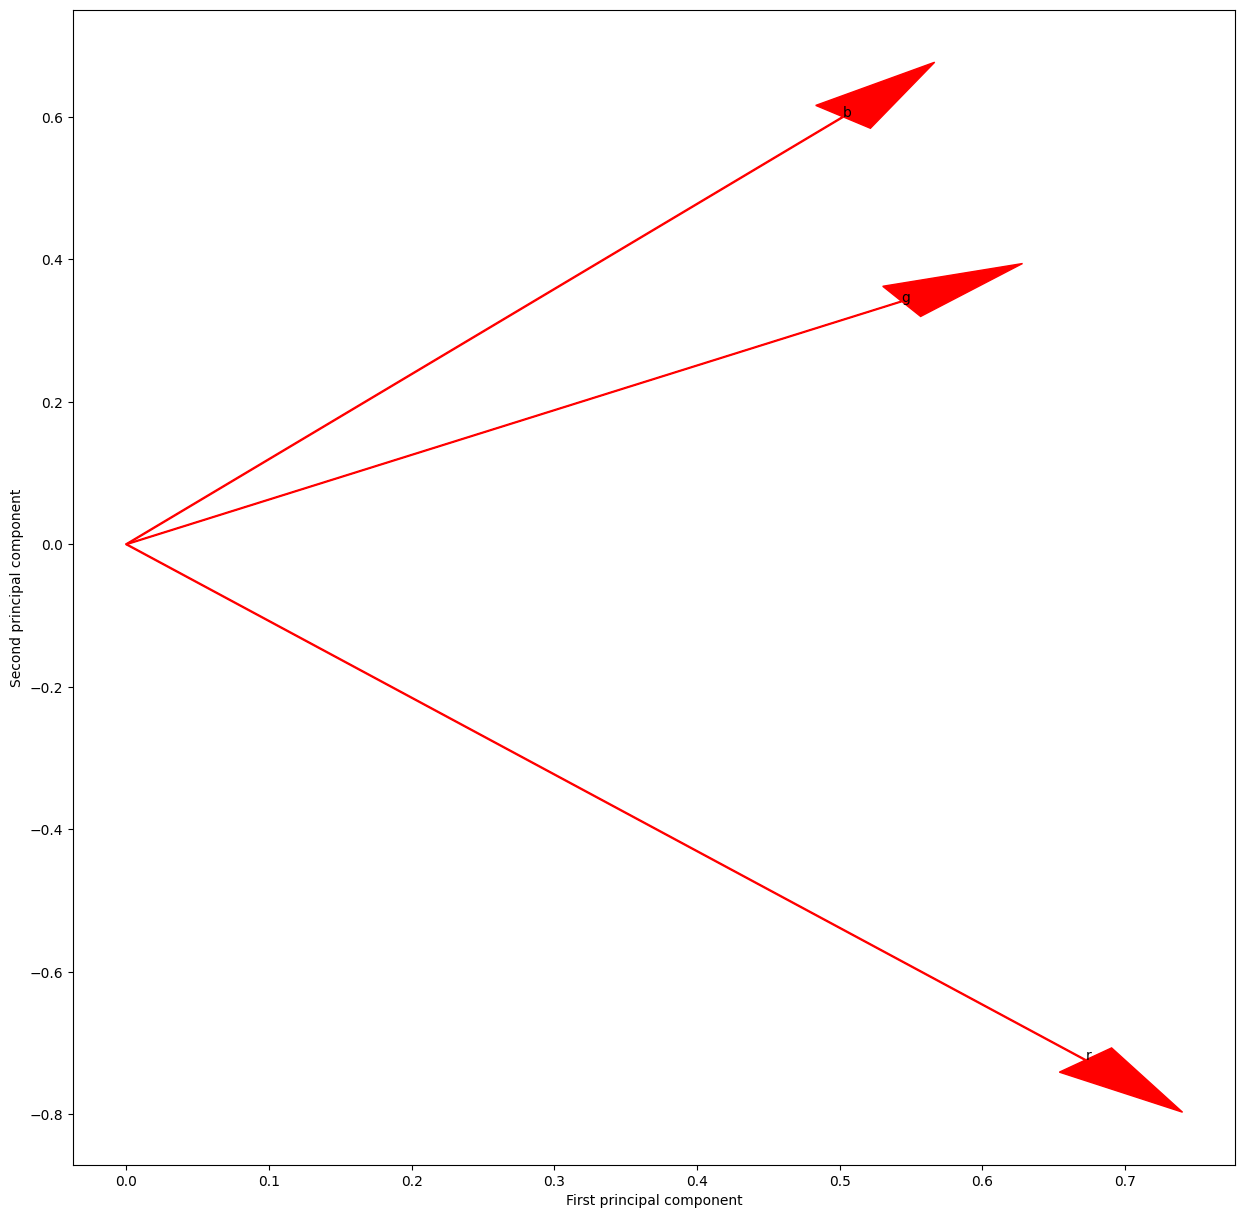

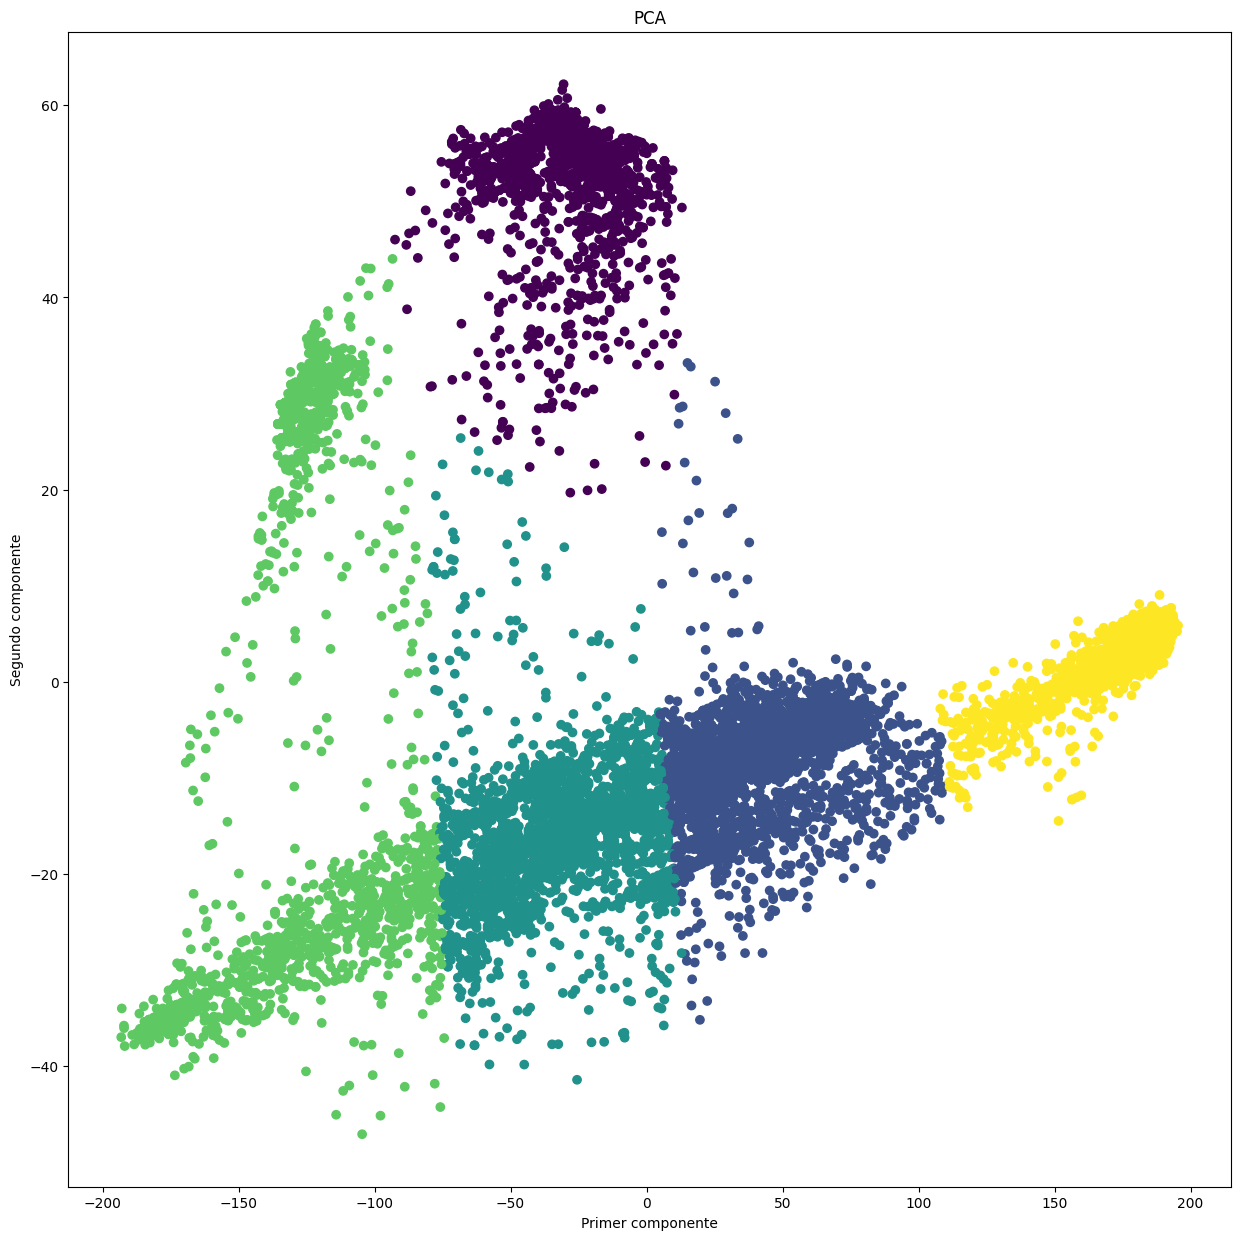

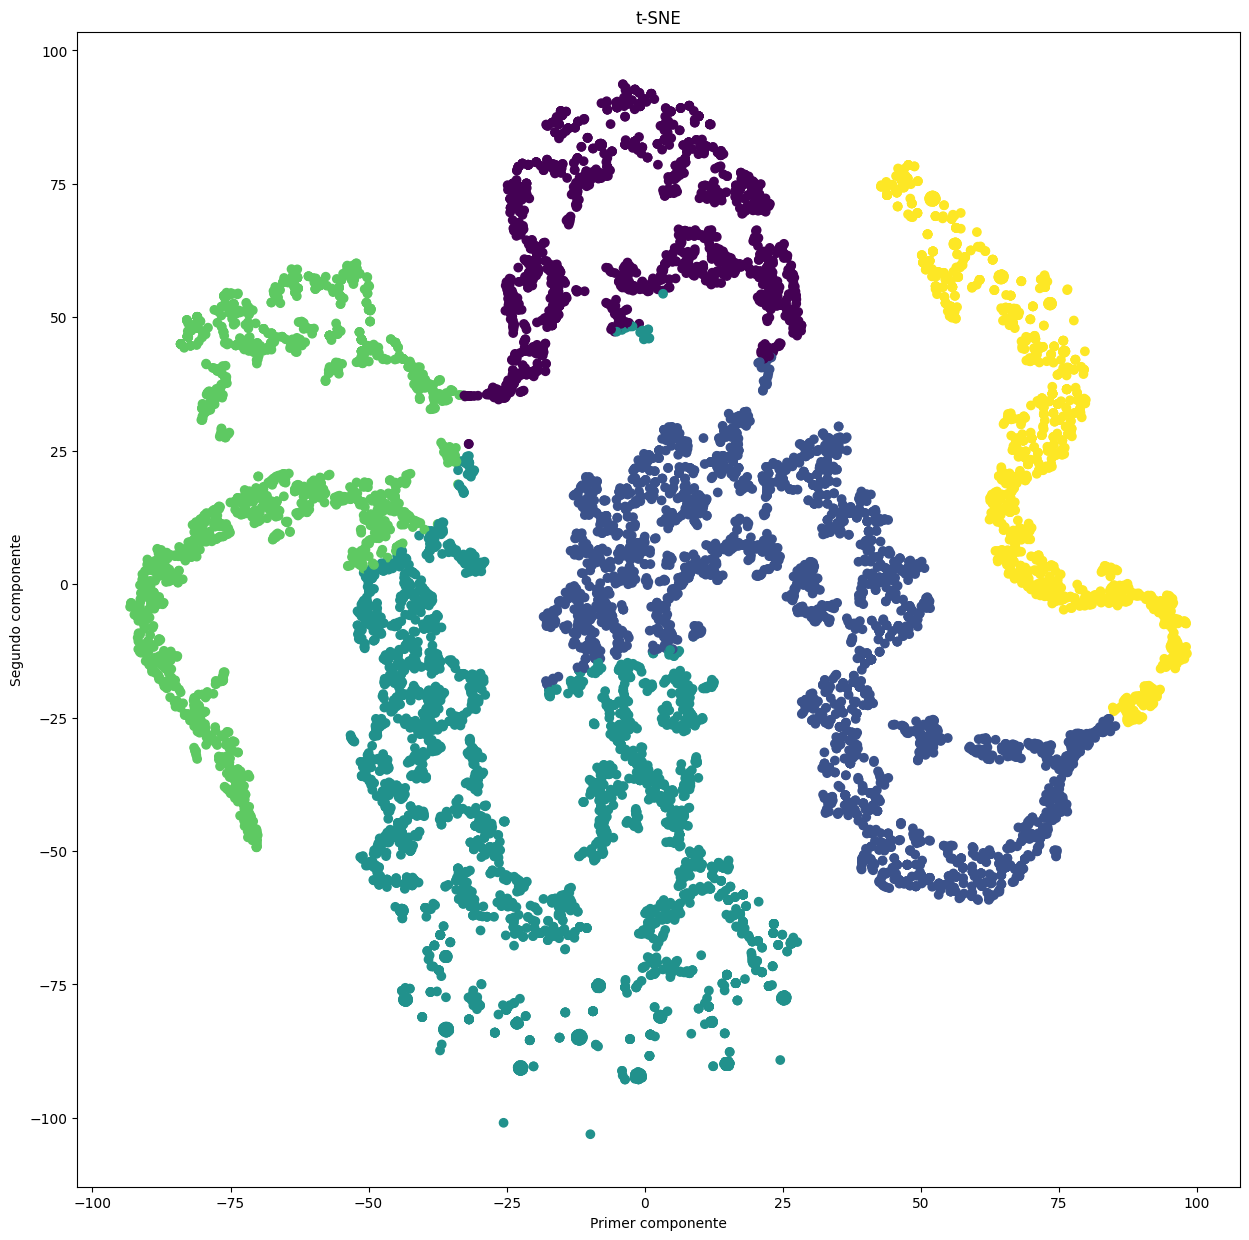

In [106]:
visual.plot(3)

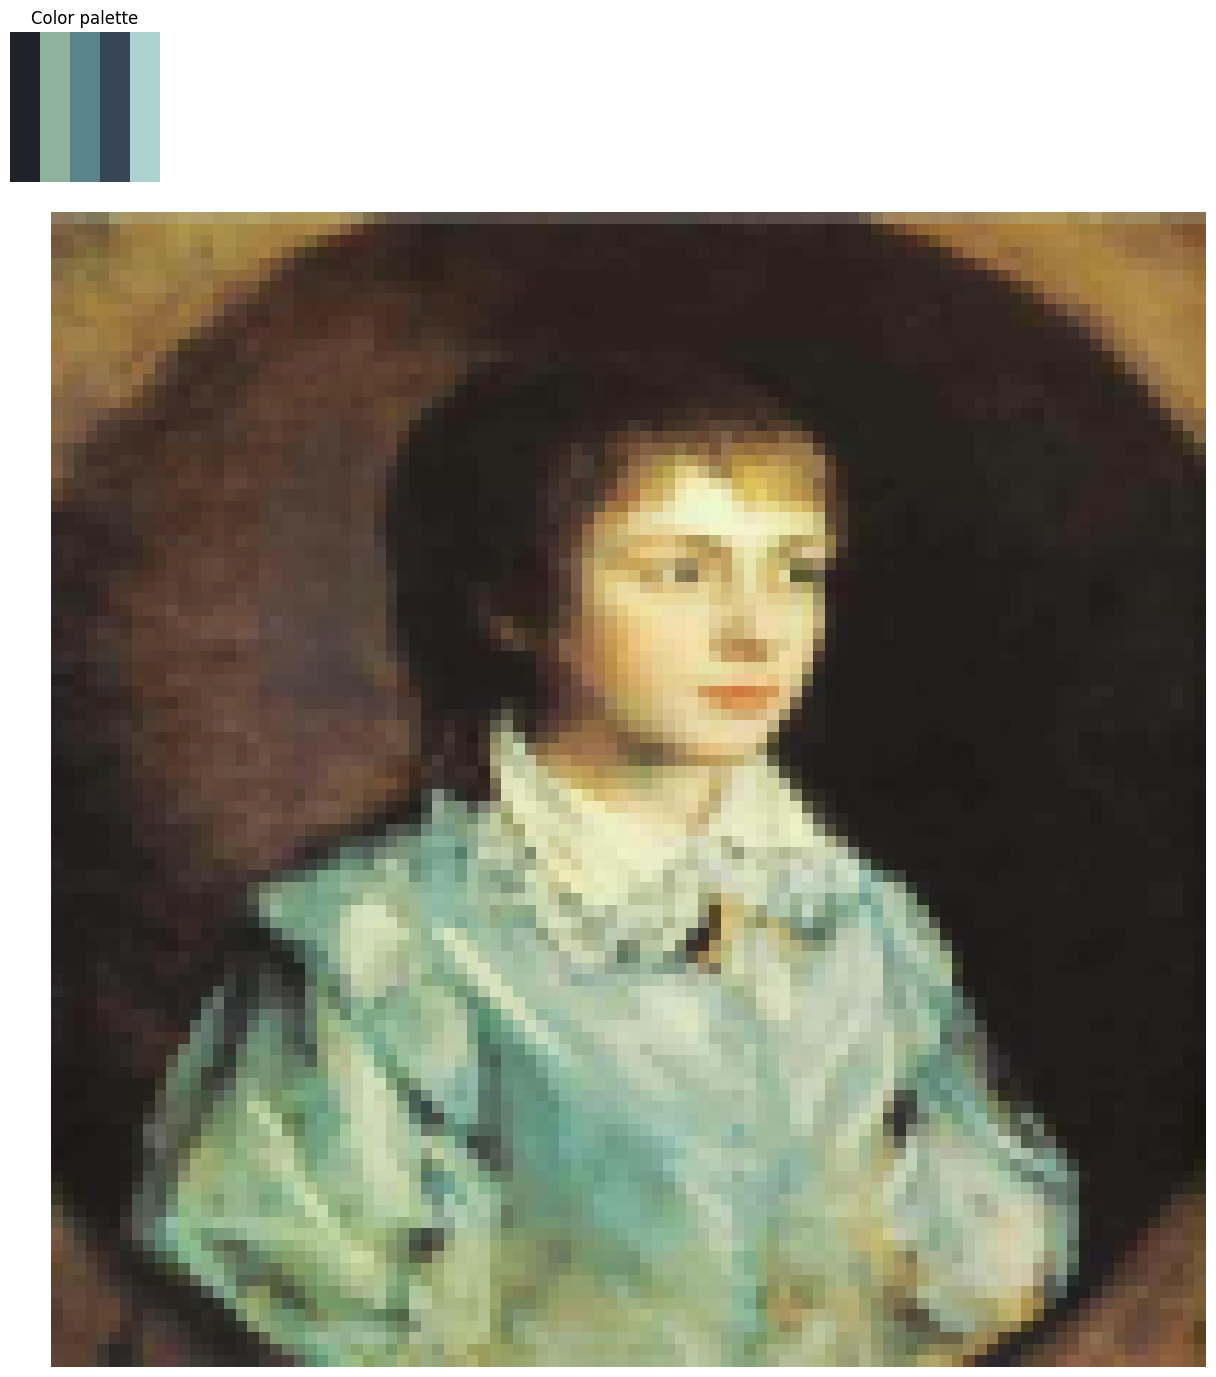

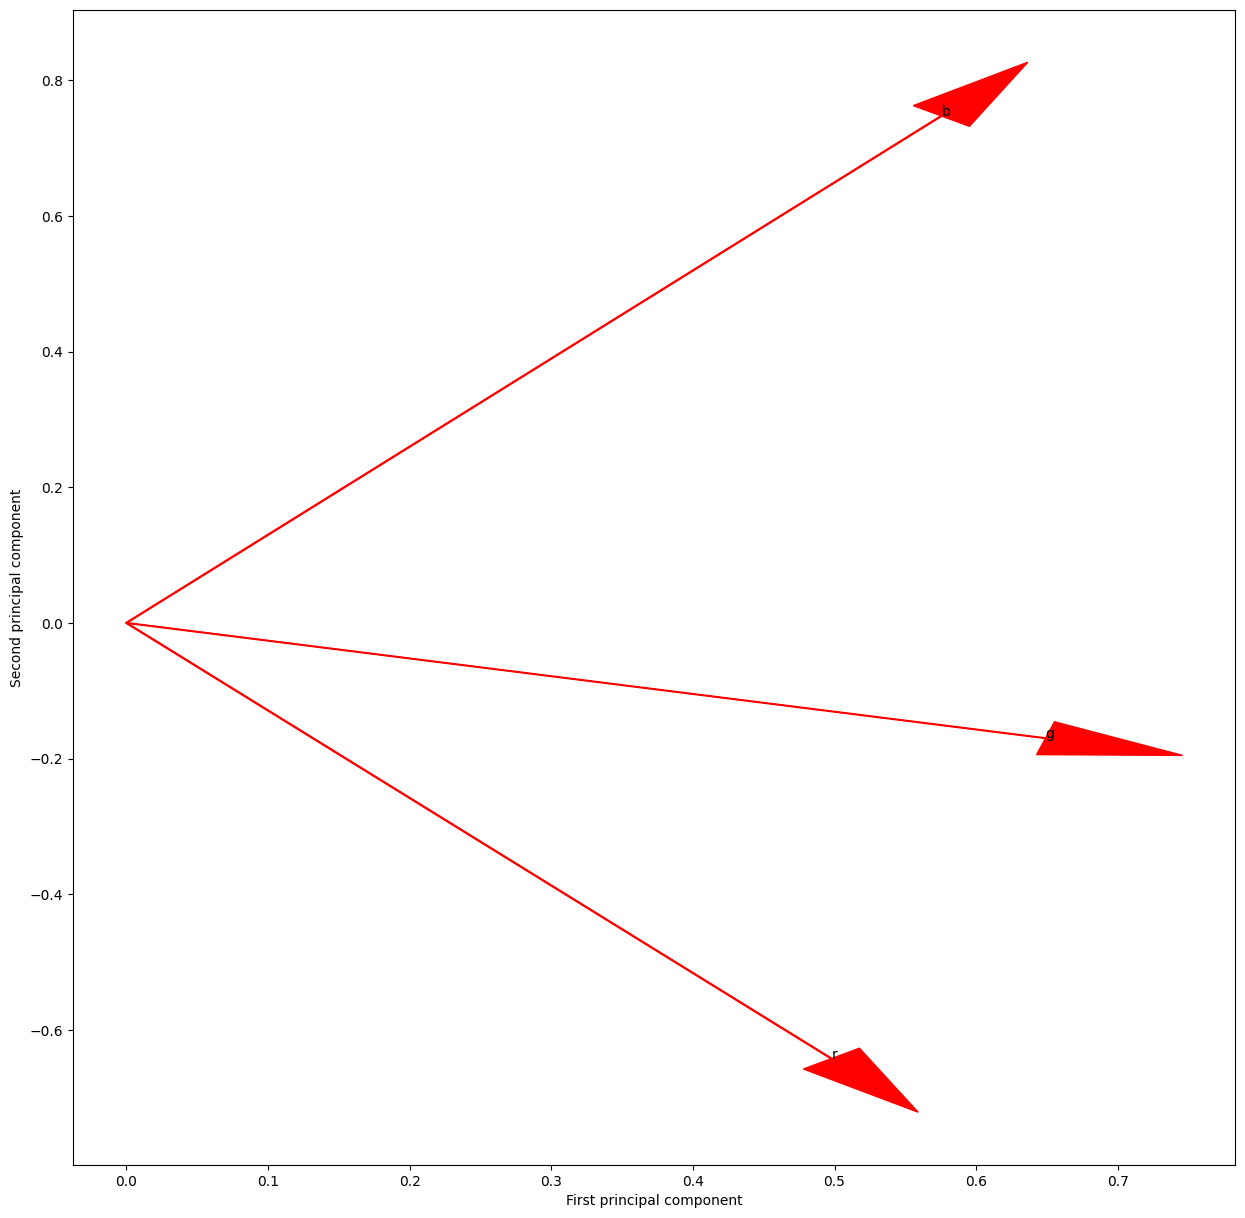

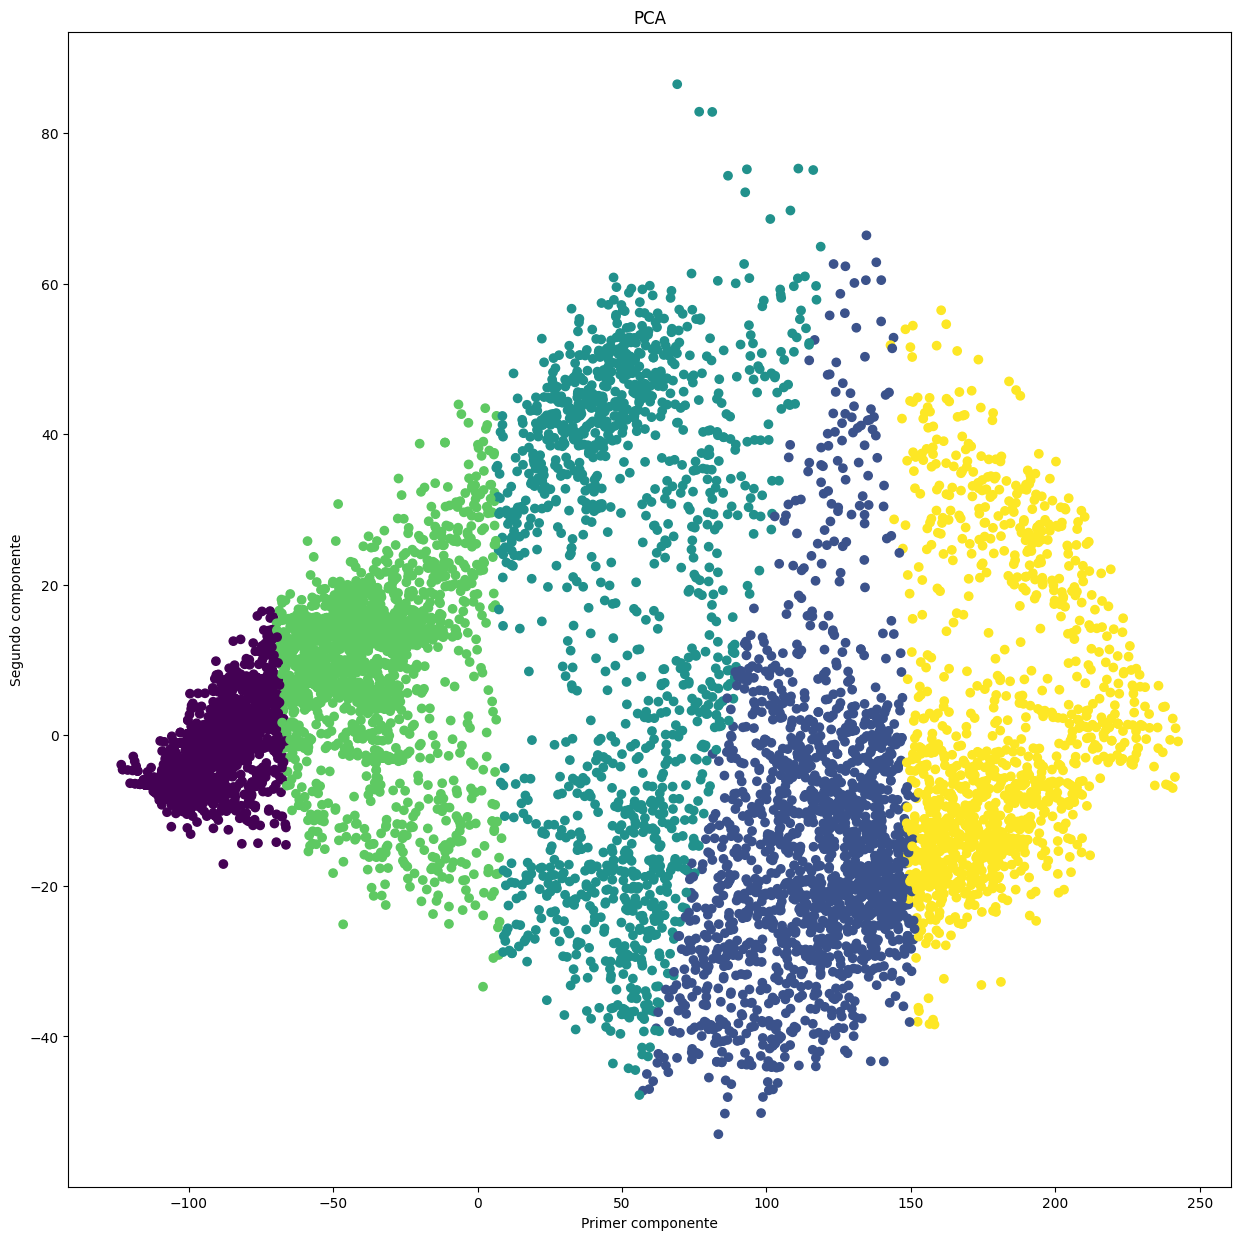

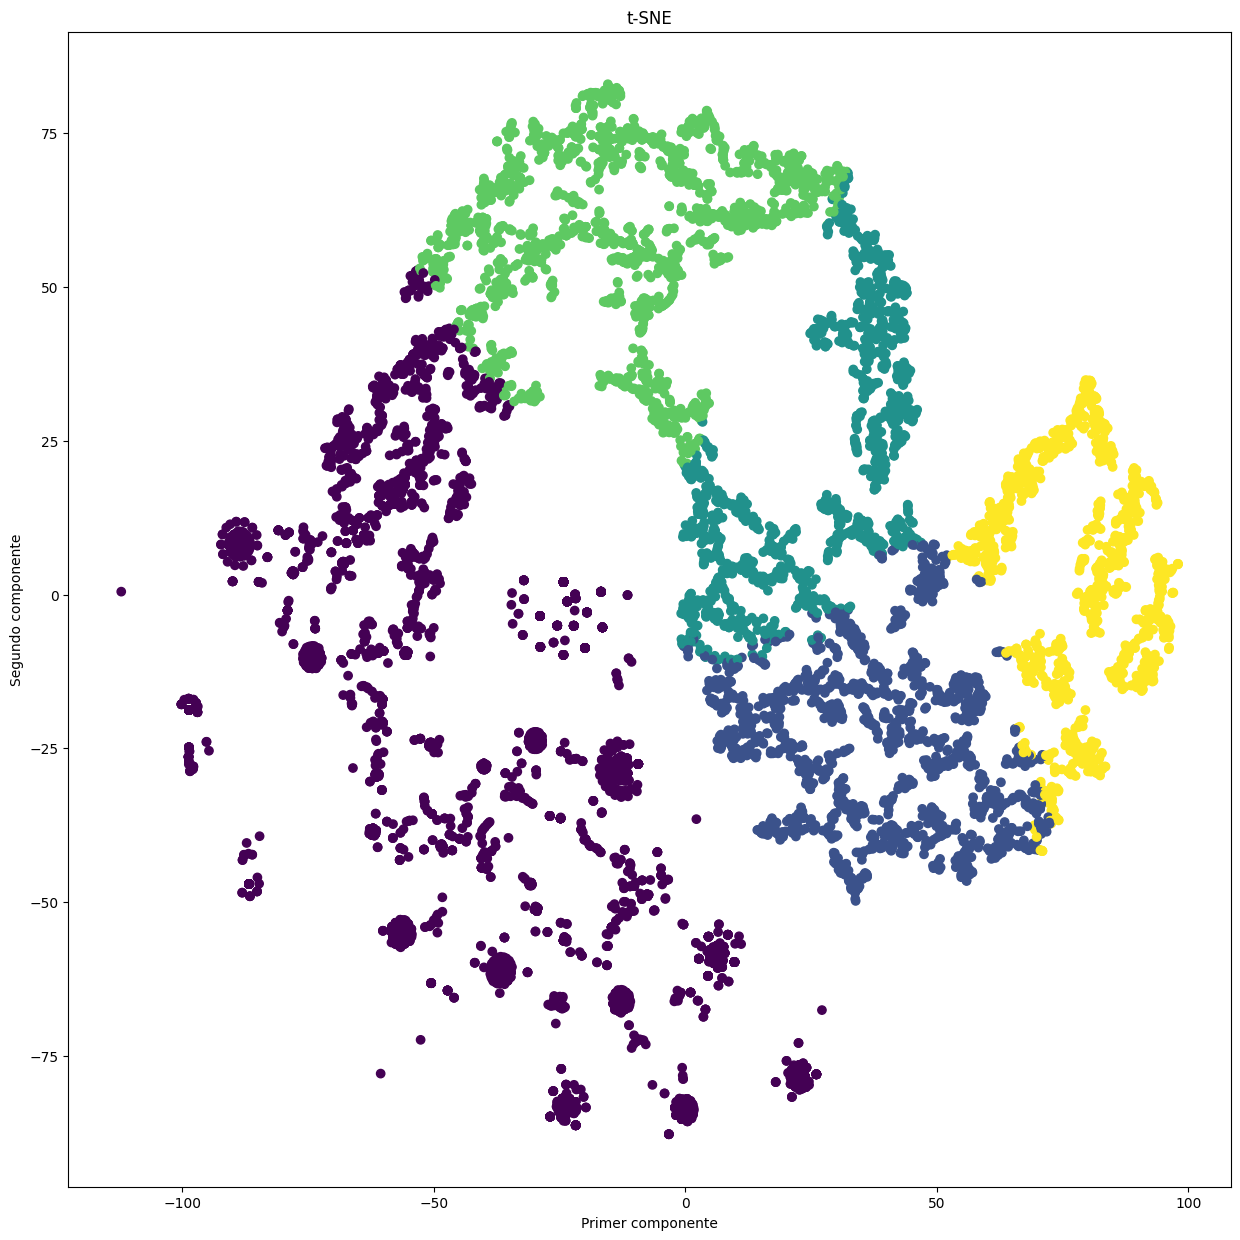

In [107]:
visual.plot(4)